# Table of Contents

- [1. Loading Libraries and Data](#loading-libraries-and-data)
- [2. Starting to Cleaning and Reading Data](#starting-to-cleaning-and-reading-data)
- [3. Drop Impractical Columns](#drop-impractical-columns)
- [4. Removing Outliers (Sales)](#removing-outliers-sales)
- [5. Prepare for Time-Series](#prepare-for-time-series)
- [6. Exploring Data (Numerical & Categorical)](#exploring-data-numerical--categorical)
- [7. Exploring Time-Series Charts](#exploring-time-series-charts)
  - [7.1 Visualize the Time Series (Line Plot)](#visualize-the-time-series-line-plot)
  - [7.2 Rolling Mean](#rolling-mean)
  - [7.3 Decomposition (Separating Trend, Seasonality, and Residuals)](#decomposition-separating-trend-seasonality-and-residuals)
  - [7.4 Seasonal Plots: Comparing Sales Across Different Time Periods](#seasonal-plots-comparing-sales-across-different-time-periods)
  - [7.5 Stationarity Check](#stationarity-check)
  - [7.6 Autocorrelation and Partial Autocorrelation](#autocorrelation-and-partial-autocorrelation)
  - [7.7 Feature Impacts](#feature-impacts)
- [8. Modelling](#modelling)
  - [8.1 ARIMA](#arima)
  - [8.2 SARIMA](#sarima)
  - [8.3 FB Prophet](#fb-prophet)



# 1. Loading Libraries and Data
<a id="loading-libraries-and-data"></a>

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
!pip install sweetviz


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 22.3 MB/s eta 0:00:00


In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
from scipy import stats
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rohitsahoo/sales-forecasting")

print("Path to dataset files:", path)

100%|██████████| 480k/480k [00:00<00:00, 74.6MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/rohitsahoo/sales-forecasting/versions/2


In [7]:
import os

# Define the directory path
dir_path = "/root/.cache/kagglehub/datasets/rohitsahoo/sales-forecasting/versions/2"

# List all files in the directory
files = os.listdir(dir_path)

# Print the file names
print(files)


['train.csv']


In [8]:
import pandas as pd

# Define the file path
file_path = "/root/.cache/kagglehub/datasets/rohitsahoo/sales-forecasting/versions/2/train.csv"

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Display the first few rows
print(df.head())


   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
1       2  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
2       3  CA-2017-138688  12/06/2017  16/06/2017    Second Class    DV-13045   
3       4  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   
4       5  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   

     Customer Name    Segment        Country             City       State  \
0      Claire Gute   Consumer  United States        Henderson    Kentucky   
1      Claire Gute   Consumer  United States        Henderson    Kentucky   
2  Darrin Van Huff  Corporate  United States      Los Angeles  California   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   

   Postal Code Region       Product ID         Cat

In [9]:
df

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9795,9796,CA-2017-125920,21/05/2017,28/05/2017,Standard Class,SH-19975,Sally Hughsby,Corporate,United States,Chicago,Illinois,60610.0,Central,OFF-BI-10003429,Office Supplies,Binders,"Cardinal HOLDit! Binder Insert Strips,Extra St...",3.7980
9796,9797,CA-2016-128608,12/01/2016,17/01/2016,Standard Class,CS-12490,Cindy Schnelling,Corporate,United States,Toledo,Ohio,43615.0,East,OFF-AR-10001374,Office Supplies,Art,"BIC Brite Liner Highlighters, Chisel Tip",10.3680
9797,9798,CA-2016-128608,12/01/2016,17/01/2016,Standard Class,CS-12490,Cindy Schnelling,Corporate,United States,Toledo,Ohio,43615.0,East,TEC-PH-10004977,Technology,Phones,GE 30524EE4,235.1880
9798,9799,CA-2016-128608,12/01/2016,17/01/2016,Standard Class,CS-12490,Cindy Schnelling,Corporate,United States,Toledo,Ohio,43615.0,East,TEC-PH-10000912,Technology,Phones,Anker 24W Portable Micro USB Car Charger,26.3760


# 2. Starting to Clean and Read Data
<a id="starting-to-cleaning-and-reading-data"></a>

In [10]:
report = sv.analyze(df)
report.show_html('report.html')

                                             |          | [  0%]   00:00 -> (? left)

Report report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [11]:
def comprehensive_df_overview(dataframe):
    print("##### Shape")
    print(dataframe.shape)
    print("\n##### Data Types")
    print(dataframe.dtypes)
    print("\n##### Columns")
    print(dataframe.columns)
    print("\n##### Index")
    print(dataframe.index)
    print("\n##### Head")
    print(dataframe.head())
    print("\n##### Tail")
    print(dataframe.tail())
    print("\n##### NA")
    print(dataframe.isnull().values.any())
    print("\n##### NA Sum - Ratio")
    print(pd.DataFrame({"na_sum": dataframe.isnull().sum(), "ratio": dataframe.isnull().sum() / dataframe.shape[0]}))

    numeric_cols = dataframe.select_dtypes(include=['number']).columns
    if not numeric_cols.empty:
        print("\n##### Basic Statistics (Numeric Columns)")
        print(dataframe[numeric_cols].describe().T)
        print("\n##### Skewness (Numeric Columns)")
        print(dataframe[numeric_cols].skew())
        print("\n##### Kurtosis (Numeric Columns)")
        print(dataframe[numeric_cols].kurtosis())
        print("\n##### Correlation Matrix (Numeric Columns)")
        print(dataframe[numeric_cols].corr())
    else:
        print("\nNo numeric columns found for statistical analysis.")

    non_numeric_cols = dataframe.select_dtypes(exclude=['number']).columns
    if not non_numeric_cols.empty:
        print("\n##### Basic Statistics (Non-Numeric Columns)")
        print(dataframe[non_numeric_cols].describe().T)
    else:
        print("\nNo non-numeric columns found for statistical analysis.")

    print("\n##### Unique Values per Column")
    print(dataframe.nunique())
    print("\n##### Sample Rows")
    print(dataframe.sample(5))
    print("\n##### Memory Usage")
    print(dataframe.memory_usage(deep=True))

comprehensive_df_overview(df)

##### Shape
(9800, 18)

##### Data Types
Row ID             int64
Order ID          object
Order Date        object
Ship Date         object
Ship Mode         object
Customer ID       object
Customer Name     object
Segment           object
Country           object
City              object
State             object
Postal Code      float64
Region            object
Product ID        object
Category          object
Sub-Category      object
Product Name      object
Sales            float64
dtype: object

##### Columns
Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales'],
      dtype='object')

##### Index
RangeIndex(start=0, stop=9800, step=1)

##### Head
   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2017-152156  08/11/2017  11/11/2017    Second

# 3. Drop Impractical Columns
<a id="drop-impractical-columns"></a>

In [12]:
df = df.drop(columns=["Row ID", "Order ID", "Ship Date", "Customer Name", "Country", "Postal Code", "Product Name"])

In [13]:
df

,Order Date,Ship Mode,Customer ID,Segment,City,State,Region,Product ID,Category,Sub-Category,Sales
0,08/11/2017,Second Class,CG-12520,Consumer,Henderson,Kentucky,South,FUR-BO-10001798,Furniture,Bookcases,261.9600
1,08/11/2017,Second Class,CG-12520,Consumer,Henderson,Kentucky,South,FUR-CH-10000454,Furniture,Chairs,731.9400
2,12/06/2017,Second Class,DV-13045,Corporate,Los Angeles,California,West,OFF-LA-10000240,Office Supplies,Labels,14.6200
3,11/10/2016,Standard Class,SO-20335,Consumer,Fort Lauderdale,Florida,South,FUR-TA-10000577,Furniture,Tables,957.5775
4,11/10/2016,Standard Class,SO-20335,Consumer,Fort Lauderdale,Florida,South,OFF-ST-10000760,Office Supplies,Storage,22.3680
...,...,...,...,...,...,...,...,...,...,...,...
9795,21/05/2017,Standard Class,SH-19975,Corporate,Chicago,Illinois,Central,OFF-BI-10003429,Office Supplies,Binders,3.7980
9796,12/01/2016,Standard Class,CS-12490,Corporate,Toledo,Ohio,East,OFF-AR-10001374,Office Supplies,Art,10.3680
9797,12/01/2016,Standard Class,CS-12490,Corporate,Toledo,Ohio,East,TEC-PH-10004977,Technology,Phones,235.1880
9798,12/01/2016,Standard Class,CS-12490,Corporate,Toledo,Ohio,East,TEC-PH-10000912,Technology,Phones,26.3760


# 4. Removing Outliers (Sales)
<a id="removing-outliers-sales"></a>

In [14]:
def handle_outliers(df, column, threshold=3):
    z_scores = np.abs(stats.zscore(df[[column]].dropna()))
    df = df[(z_scores < threshold).all(axis=1)]

    return df

In [15]:
df = handle_outliers(df, "Sales")

In [16]:
df

,Order Date,Ship Mode,Customer ID,Segment,City,State,Region,Product ID,Category,Sub-Category,Sales
0,08/11/2017,Second Class,CG-12520,Consumer,Henderson,Kentucky,South,FUR-BO-10001798,Furniture,Bookcases,261.9600
1,08/11/2017,Second Class,CG-12520,Consumer,Henderson,Kentucky,South,FUR-CH-10000454,Furniture,Chairs,731.9400
2,12/06/2017,Second Class,DV-13045,Corporate,Los Angeles,California,West,OFF-LA-10000240,Office Supplies,Labels,14.6200
3,11/10/2016,Standard Class,SO-20335,Consumer,Fort Lauderdale,Florida,South,FUR-TA-10000577,Furniture,Tables,957.5775
4,11/10/2016,Standard Class,SO-20335,Consumer,Fort Lauderdale,Florida,South,OFF-ST-10000760,Office Supplies,Storage,22.3680
...,...,...,...,...,...,...,...,...,...,...,...
9795,21/05/2017,Standard Class,SH-19975,Corporate,Chicago,Illinois,Central,OFF-BI-10003429,Office Supplies,Binders,3.7980
9796,12/01/2016,Standard Class,CS-12490,Corporate,Toledo,Ohio,East,OFF-AR-10001374,Office Supplies,Art,10.3680
9797,12/01/2016,Standard Class,CS-12490,Corporate,Toledo,Ohio,East,TEC-PH-10004977,Technology,Phones,235.1880
9798,12/01/2016,Standard Class,CS-12490,Corporate,Toledo,Ohio,East,TEC-PH-10000912,Technology,Phones,26.3760


# 5. Prepare for Time-Series
<a id="prepare-for-time-series"></a>

In [17]:
def prepare_for_timeseries(dataframe):
    dataframe['Order Date'] = pd.to_datetime(dataframe['Order Date'], format='%d/%m/%Y', errors='coerce')

    dataframe = dataframe.sort_values(by='Order Date')

    dataframe.reset_index(drop=True, inplace=True)

    print("##### Data Preparation Completed")
    print("\n##### Sorted DataFrame Head")
    print(dataframe.head())

    return dataframe

df = prepare_for_timeseries(df)

##### Data Preparation Completed

##### Sorted DataFrame Head
  Order Date       Ship Mode Customer ID      Segment          City  \
0 2015-01-03  Standard Class    DP-13000     Consumer       Houston   
1 2015-01-04  Standard Class    PO-19195  Home Office    Naperville   
2 2015-01-04  Standard Class    PO-19195  Home Office    Naperville   
3 2015-01-04  Standard Class    PO-19195  Home Office    Naperville   
4 2015-01-05  Standard Class    MB-18085     Consumer  Philadelphia   

          State   Region       Product ID         Category Sub-Category  \
0         Texas  Central  OFF-PA-10000174  Office Supplies        Paper   
1      Illinois  Central  OFF-BI-10004094  Office Supplies      Binders   
2      Illinois  Central  OFF-ST-10002743  Office Supplies      Storage   
3      Illinois  Central  OFF-LA-10003223  Office Supplies       Labels   
4  Pennsylvania     East  OFF-AR-10003478  Office Supplies          Art   

     Sales  
0   16.448  
1    3.540  
2  272.736  
3   11.7

In [18]:
df

,Order Date,Ship Mode,Customer ID,Segment,City,State,Region,Product ID,Category,Sub-Category,Sales
0,2015-01-03,Standard Class,DP-13000,Consumer,Houston,Texas,Central,OFF-PA-10000174,Office Supplies,Paper,16.448
1,2015-01-04,Standard Class,PO-19195,Home Office,Naperville,Illinois,Central,OFF-BI-10004094,Office Supplies,Binders,3.540
2,2015-01-04,Standard Class,PO-19195,Home Office,Naperville,Illinois,Central,OFF-ST-10002743,Office Supplies,Storage,272.736
3,2015-01-04,Standard Class,PO-19195,Home Office,Naperville,Illinois,Central,OFF-LA-10003223,Office Supplies,Labels,11.784
4,2015-01-05,Standard Class,MB-18085,Consumer,Philadelphia,Pennsylvania,East,OFF-AR-10003478,Office Supplies,Art,19.536
...,...,...,...,...,...,...,...,...,...,...,...
9672,2018-12-30,Standard Class,PO-18865,Consumer,New York City,New York,East,OFF-BI-10003684,Office Supplies,Binders,52.776
9673,2018-12-30,Standard Class,EB-13975,Corporate,Fairfield,California,West,OFF-BI-10002103,Office Supplies,Binders,13.904
9674,2018-12-30,Standard Class,EB-13975,Corporate,Fairfield,California,West,OFF-BI-10004632,Office Supplies,Binders,20.720
9675,2018-12-30,Standard Class,JM-15580,Consumer,Loveland,Colorado,West,OFF-FA-10003472,Office Supplies,Fasteners,3.024


# 6. Exploring Data (Numerical & Categorical)
<a id="exploring-data"></a>

In [19]:
def fetch_col_names(dataframe):
    # Categorical columns: columns with object dtype
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtype == 'O']

    # Numerical columns: columns with non-object dtype
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]

    return cat_cols, num_cols

cat_cols, num_cols = fetch_col_names(df)

In [20]:
cat_cols

['Ship Mode',
 'Customer ID',
 'Segment',
 'City',
 'State',
 'Region',
 'Product ID',
 'Category',
 'Sub-Category']

In [21]:
num_cols

['Order Date', 'Sales']

In [22]:
def cat_details(dataframe, col_name, plot=False):
    # Count and ratio of unique values
    value_counts = dataframe[col_name].value_counts()
    ratio = 100 * value_counts / len(dataframe)

    # Calculate the length of the summary line
    summary_length = len(col_name) + len(" Details ")
    border_length = max(50, summary_length + 4)

    # Create border lines
    top_border = '#' * border_length
    middle_border = f"{'#' * 10} {col_name} Details {'#' * 10}".center(border_length, '#')
    bottom_border = '#' * border_length

    # Print summary
    print(f"\n{top_border}")
    print(middle_border)
    print(pd.DataFrame({col_name: value_counts, "Ratio (%)": ratio}))
    print(f"\n{col_name} has {dataframe[col_name].nunique()} unique values.")
    print(f"{bottom_border}\n")

    # Plot count plot if plot is True
    if plot:
        plt.figure(figsize=(10, 6))
        plt.bar(value_counts.index, value_counts.values)
        plt.title(f"Count Plot for {col_name}")
        plt.xlabel(col_name)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()


##################################################
############### Ship Mode Details ################
                Ship Mode  Ratio (%)
Ship Mode                           
Standard Class       5788  59.811925
Second Class         1877  19.396507
First Class          1481  15.304330
Same Day              531   5.487238

Ship Mode has 4 unique values.
##################################################



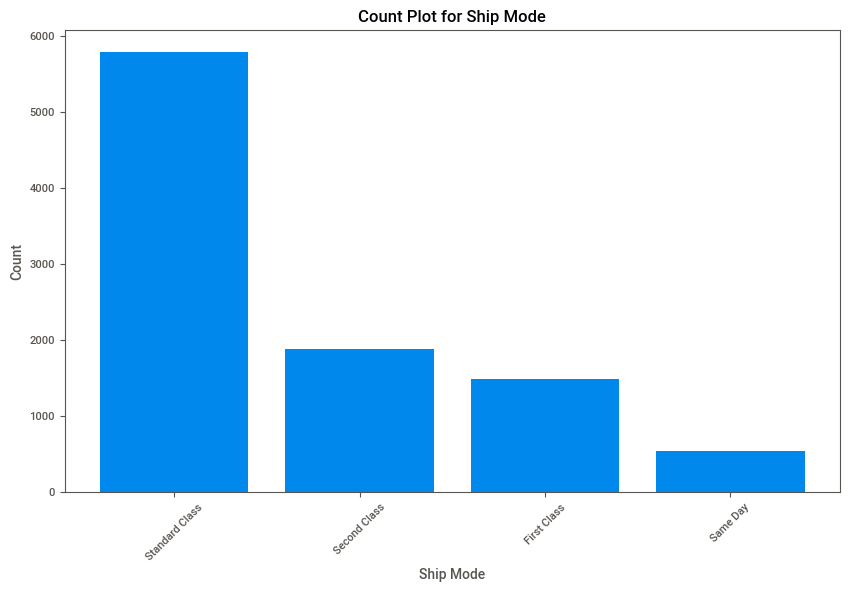


##################################################
################ Segment Details #################
             Segment  Ratio (%)
Segment                        
Consumer        5041  52.092591
Corporate       2917  30.143640
Home Office     1719  17.763770

Segment has 3 unique values.
##################################################



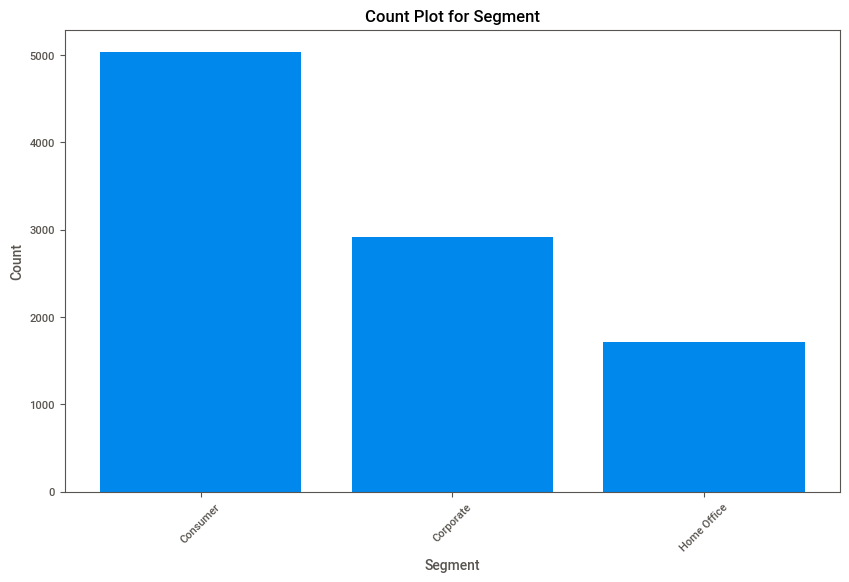


##################################################
################# State Details ##################
                      State  Ratio (%)
State                                 
California             1923  19.871861
New York               1070  11.057146
Texas                   965   9.972099
Pennsylvania            578   5.972925
Washington              496   5.125555
Illinois                481   4.970549
Ohio                    453   4.681203
Florida                 370   3.823499
Michigan                248   2.562778
North Carolina          244   2.521443
Arizona                 223   2.304433
Virginia                218   2.252764
Tennessee               181   1.870414
Colorado                178   1.839413
Georgia                 173   1.787744
Massachusetts           135   1.395060
Kentucky                134   1.384727
Indiana                 133   1.374393
Oregon                  122   1.260721
New Jersey              118   1.219386
Maryland                104   1.074713


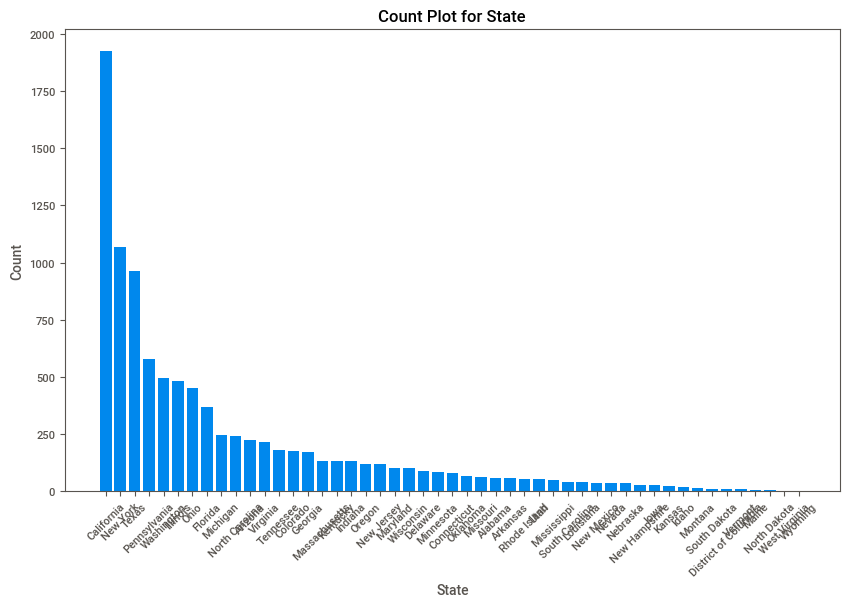


##################################################
################# Region Details #################
         Region  Ratio (%)
Region                    
West       3105  32.086390
East       2743  28.345562
Central    2254  23.292343
South      1575  16.275705

Region has 4 unique values.
##################################################



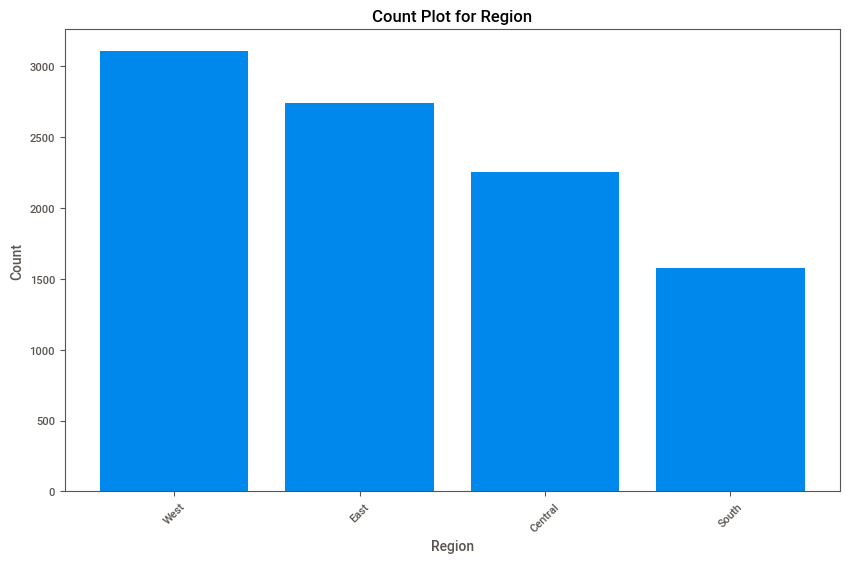


##################################################
################ Category Details ################
                 Category  Ratio (%)
Category                            
Office Supplies      5880  60.762633
Furniture            2046  21.142916
Technology           1751  18.094451

Category has 3 unique values.
##################################################



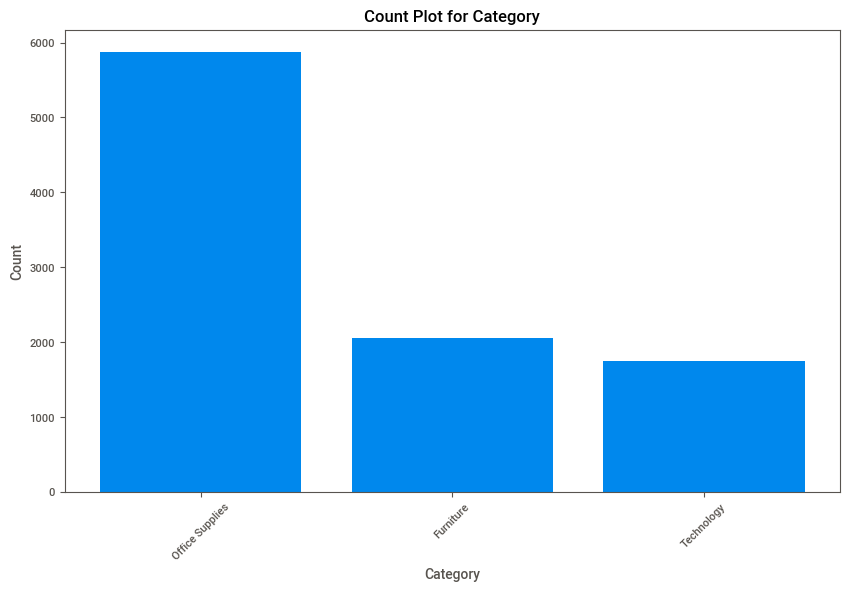


##################################################
############## Sub-Category Details ##############
              Sub-Category  Ratio (%)
Sub-Category                         
Binders               1474  15.231993
Paper                 1338  13.826599
Furnishings            931   9.620750
Phones                 864   8.928387
Storage                830   8.577038
Art                    785   8.112018
Accessories            752   7.771003
Chairs                 592   6.117598
Appliances             456   4.712204
Labels                 357   3.689160
Tables                 304   3.141469
Envelopes              248   2.562778
Bookcases              219   2.263098
Fasteners              214   2.211429
Supplies               178   1.839413
Machines                86   0.888705
Copiers                 49   0.506355

Sub-Category has 17 unique values.
##################################################



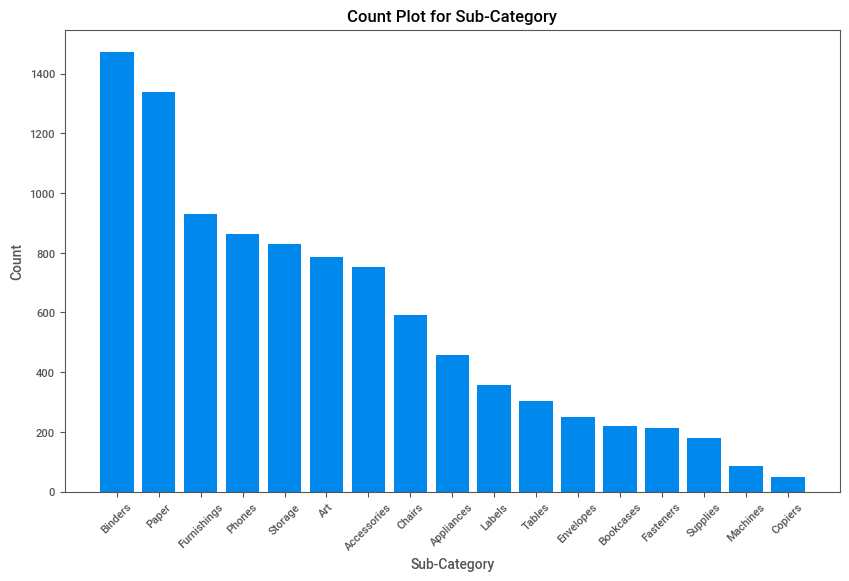

In [23]:
for col in ["Ship Mode", "Segment", "State", "Region", "Category", "Sub-Category"]:
    cat_details(df, col, plot=True)

In [24]:
def num_details(dataframe, col_name, plot=False, quantiles=[0.05, 0.10, 0.20, 0.50, 0.60, 0.80, 0.90, 0.95, 0.99]):
    if plot:
        dataframe[col_name].hist(bins=20)
        plt.xlabel(col_name)
        plt.title(col_name)
        plt.show(block=True)

    # Calculate the length of the summary line
    summary_length = len(col_name) + len(" Details ")
    border_length = max(50, summary_length + 4)

    # Create border lines
    top_border = '#' * border_length
    middle_border = f"{'#' * 10} {col_name} Details {'#' * 10}".center(border_length, '#')
    bottom_border = '#' * border_length

    # Print summary
    print(f"\n{top_border}")
    print(middle_border)
    print(dataframe[col_name].describe(percentiles=quantiles).T, end="\n\n")
    print(f"{bottom_border}\n")

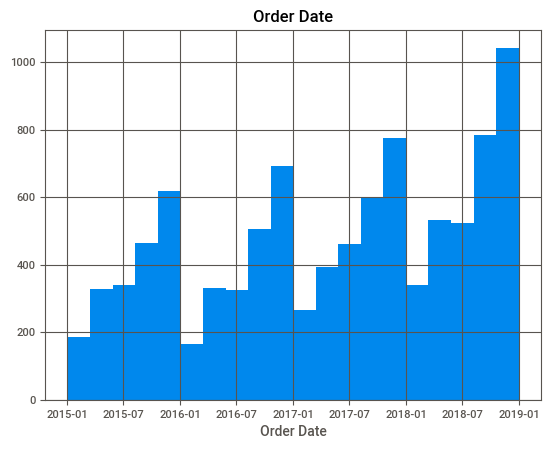


##################################################
############### Order Date Details ###############
count                             9677
mean     2017-05-01 09:22:02.517309184
min                2015-01-03 00:00:00
5%                 2015-05-21 19:12:00
10%                2015-09-07 00:00:00
20%                2016-01-03 00:00:00
50%                2017-06-26 00:00:00
60%                2017-11-04 00:00:00
80%                2018-07-20 00:00:00
90%                2018-10-23 00:00:00
95%                2018-11-28 00:00:00
99%                2018-12-22 05:45:36
max                2018-12-30 00:00:00
Name: Order Date, dtype: object

##################################################



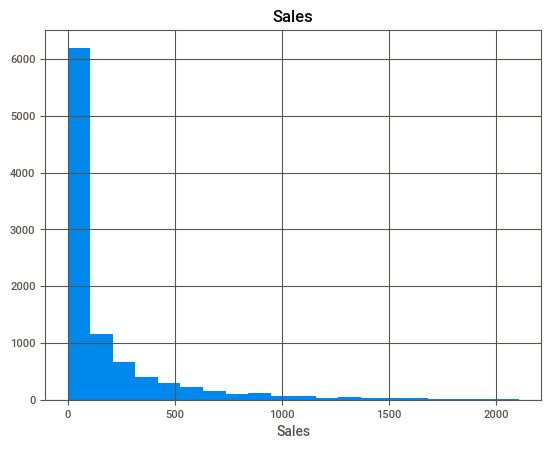


##################################################
################# Sales Details ##################
count    9677.000000
mean      181.523961
std       305.877098
min         0.444000
5%          4.928000
10%         7.858800
20%        13.499200
50%        52.200000
60%        86.291200
80%       269.490000
90%       526.502800
95%       841.724800
99%      1569.780720
max      2104.550000
Name: Sales, dtype: float64

##################################################



In [25]:
for col in num_cols:
    num_details(df, col, plot=True)

# 7. Exploring Time-Series Charts
<a id="exploring-time-series-charts"></a>

## 7.1 Visualize the Time Series (Line Plot)
<a id="visualize-time-series"></a>

In [26]:
df['month'] = pd.to_datetime(df['Order Date']).dt.to_period('M')
df.head()
mdf = df.groupby('month')['Sales'].sum()
mdf = pd.DataFrame(mdf)
mdf['time'] = np.arange(len(mdf.index))
mdf.head()

,Sales,time
month,,
2015-01,11631.887,0
2015-02,4519.892,1
2015-03,29067.387,2
2015-04,23742.805,3
2015-05,20928.373,4


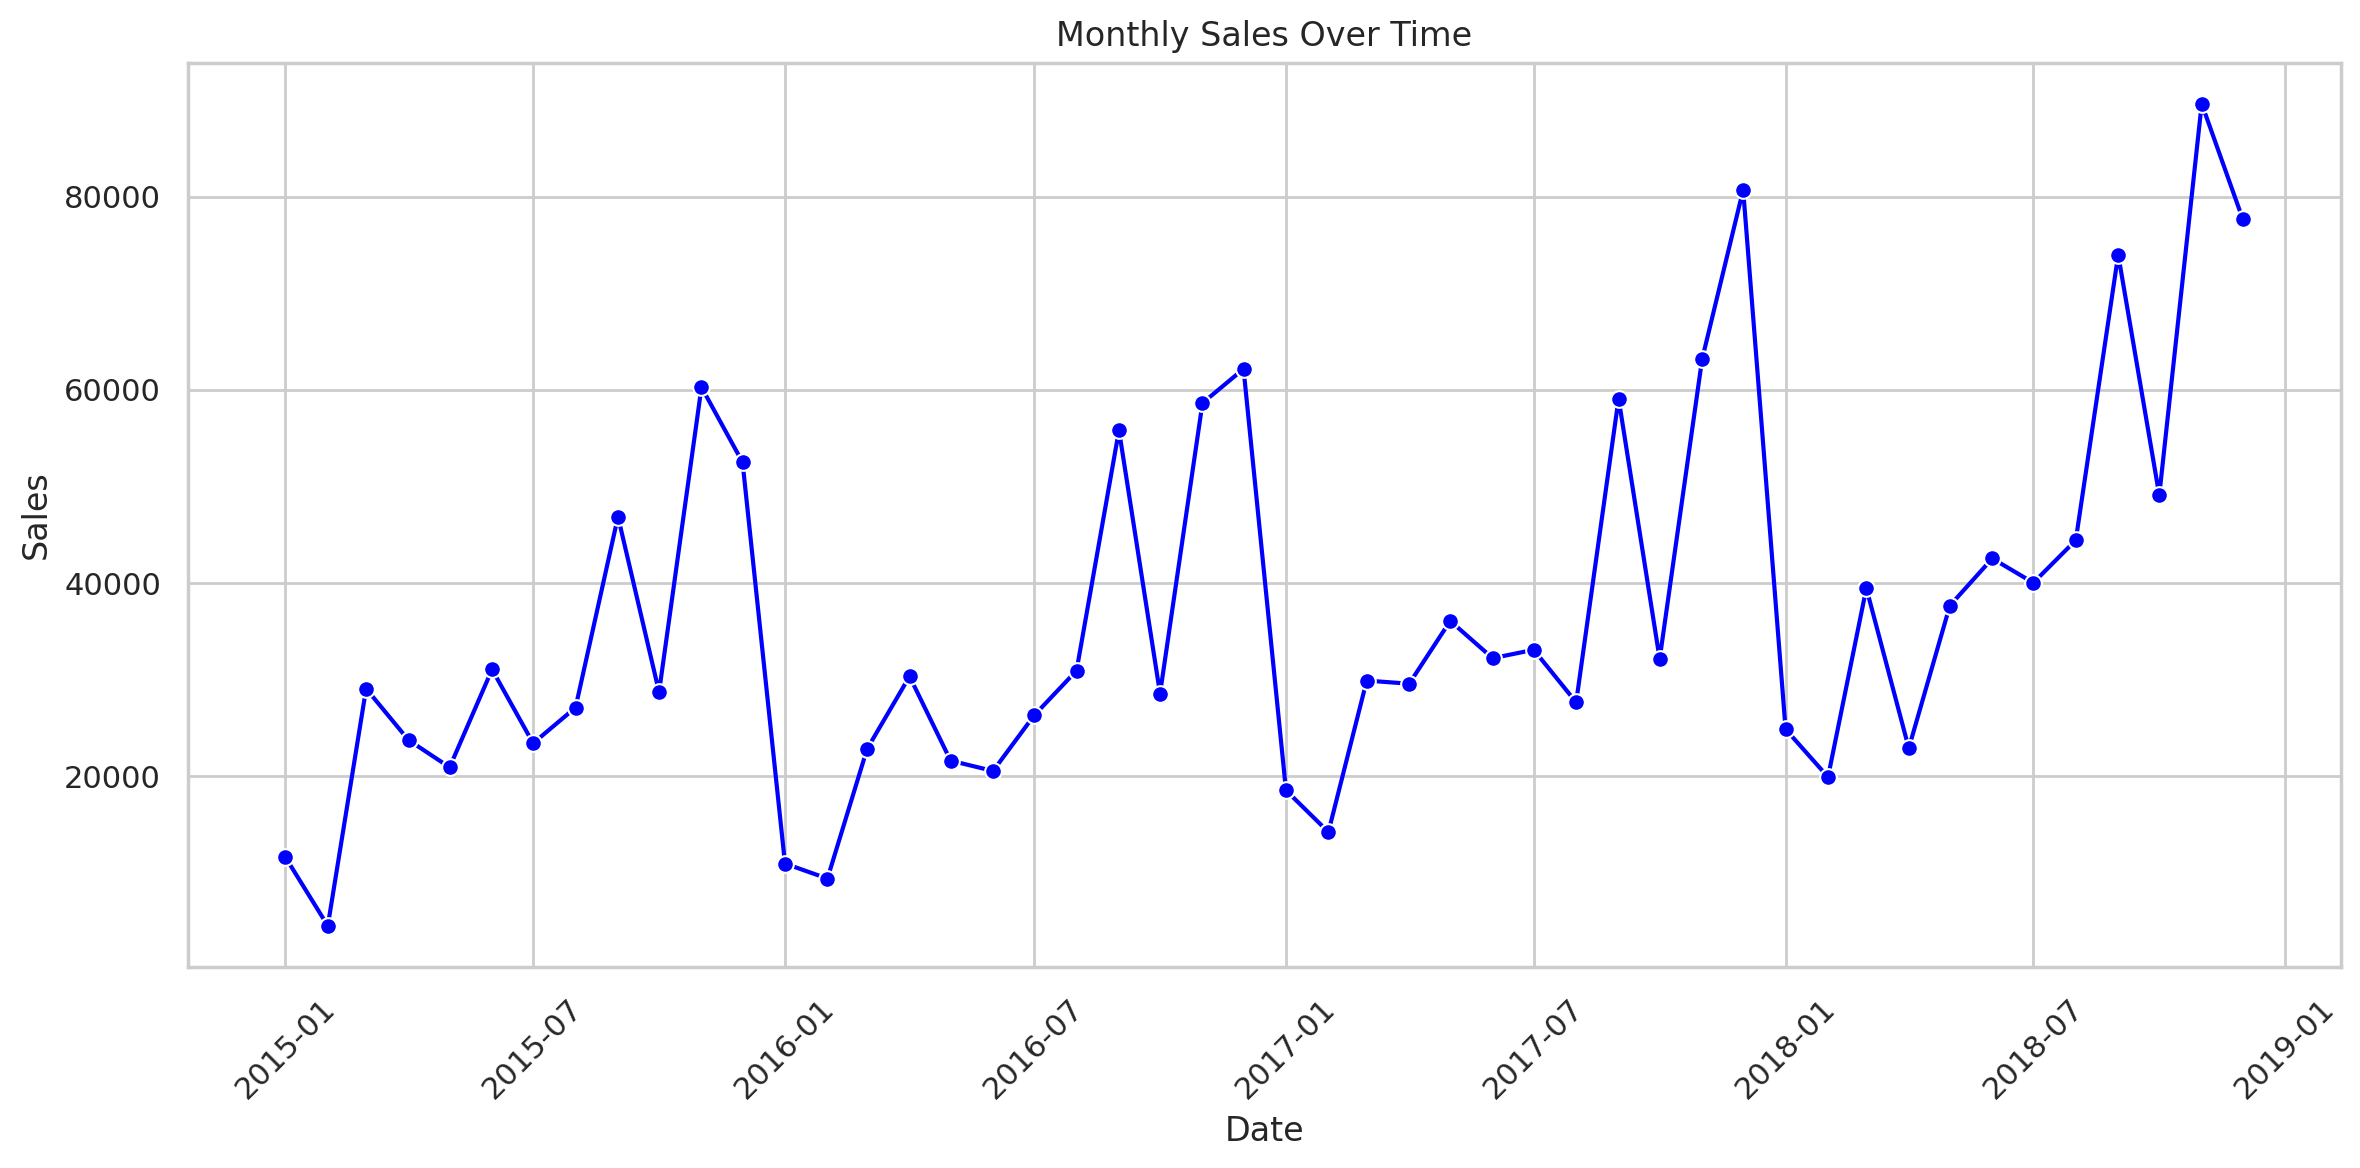

In [27]:
sns.set(style='whitegrid')
plt.figure(figsize=(12, 6), dpi=200)

if isinstance(mdf.index, pd.PeriodIndex):
    mdf.index = mdf.index.to_timestamp()

sns.lineplot(data=mdf, x=mdf.index, y='Sales', marker='o', color='blue')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Monthly Sales Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 7.2 Rolling Mean
<a id="rolling-mean"></a>

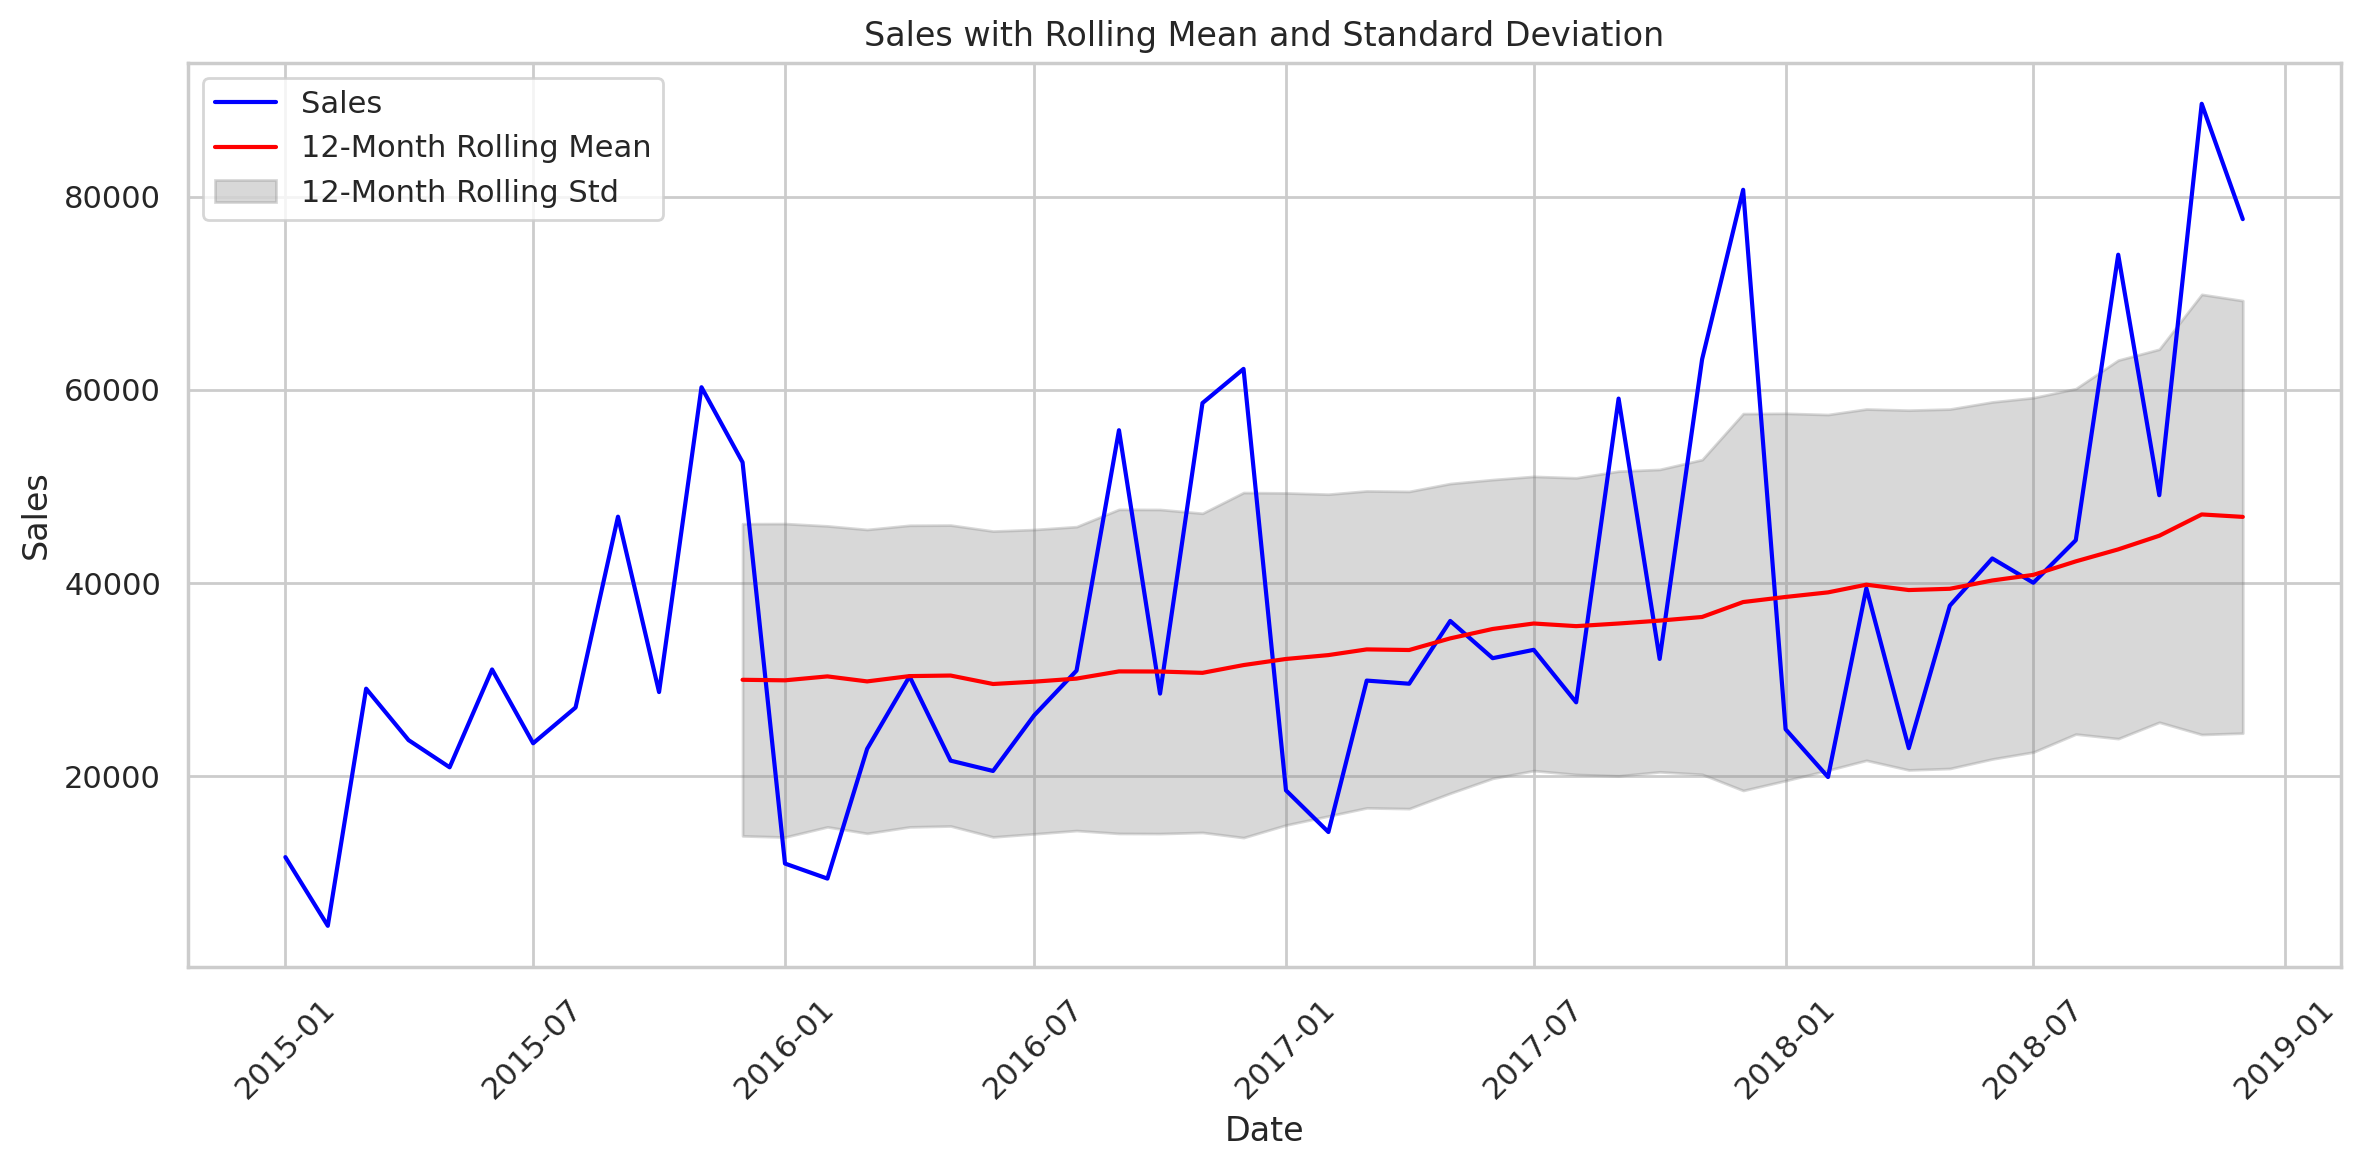

In [28]:
# Set the rolling window size (12 months)
window_size = 12

# Calculate the rolling mean and standard deviation
mdf['Rolling_Mean'] = mdf['Sales'].rolling(window=window_size).mean()
mdf['Rolling_Std'] = mdf['Sales'].rolling(window=window_size).std()

# Plot the original sales data
plt.figure(figsize=(12, 6), dpi=200)
sns.lineplot(data=mdf, x=mdf.index, y='Sales', label='Sales', color='blue')

# Plot the rolling mean
sns.lineplot(data=mdf, x=mdf.index, y='Rolling_Mean', label=f'{window_size}-Month Rolling Mean', color='red')

# Plot the rolling standard deviation (as a shaded area to indicate volatility)
plt.fill_between(mdf.index, mdf['Rolling_Mean'] - mdf['Rolling_Std'], mdf['Rolling_Mean'] + mdf['Rolling_Std'],
                 color='gray', alpha=0.3, label=f'{window_size}-Month Rolling Std')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales with Rolling Mean and Standard Deviation')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 7.3 Decomposition (Separating Trend, Seasonality, and Residuals)
<a id="decomposition"></a>

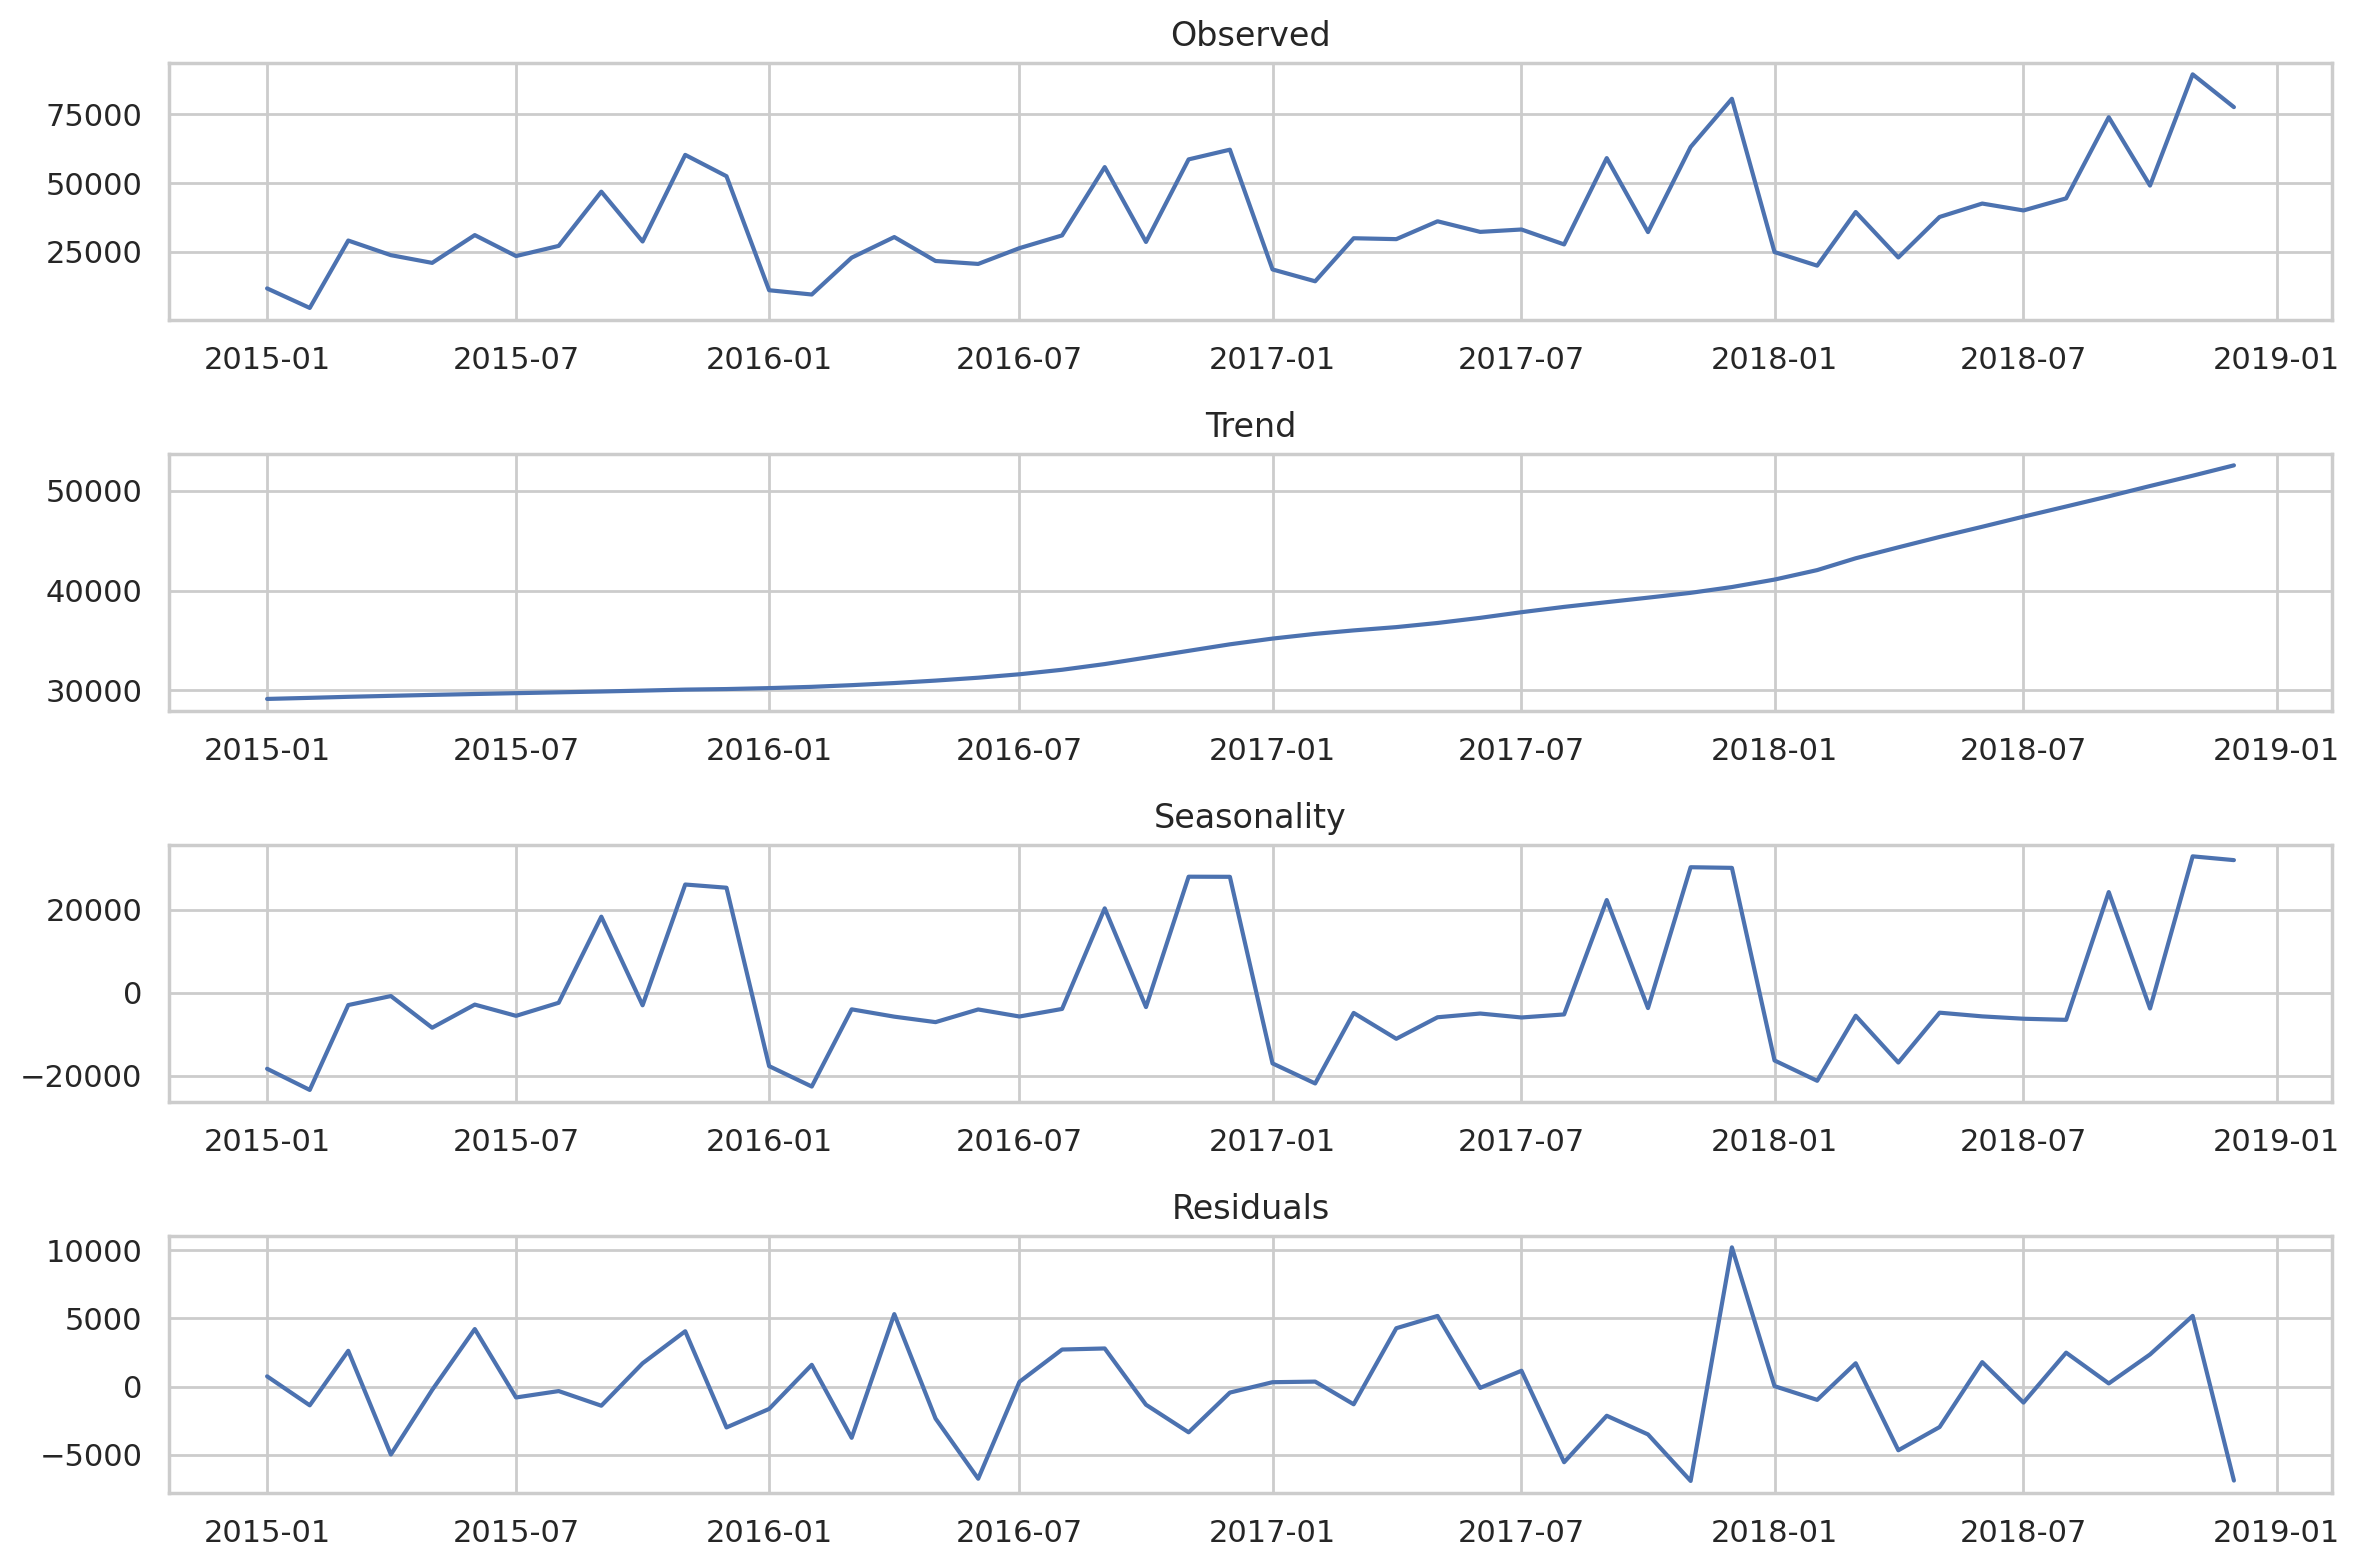

In [29]:
# Apply STL decomposition
stl = STL(mdf['Sales'], seasonal=13)
result = stl.fit()

# Plot the decomposition
plt.figure(figsize=(12, 8), dpi=200)

plt.subplot(4, 1, 1)
plt.plot(mdf.index, result.observed)
plt.title('Observed')

plt.subplot(4, 1, 2)
plt.plot(mdf.index, result.trend)
plt.title('Trend')

plt.subplot(4, 1, 3)
plt.plot(mdf.index, result.seasonal)
plt.title('Seasonality')

plt.subplot(4, 1, 4)
plt.plot(mdf.index, result.resid)
plt.title('Residuals')

plt.tight_layout()
plt.show()

## 7.4 Seasonal Plots: Comparing Sales Across Different Time Periods
<a id="seasonal-plots"></a>

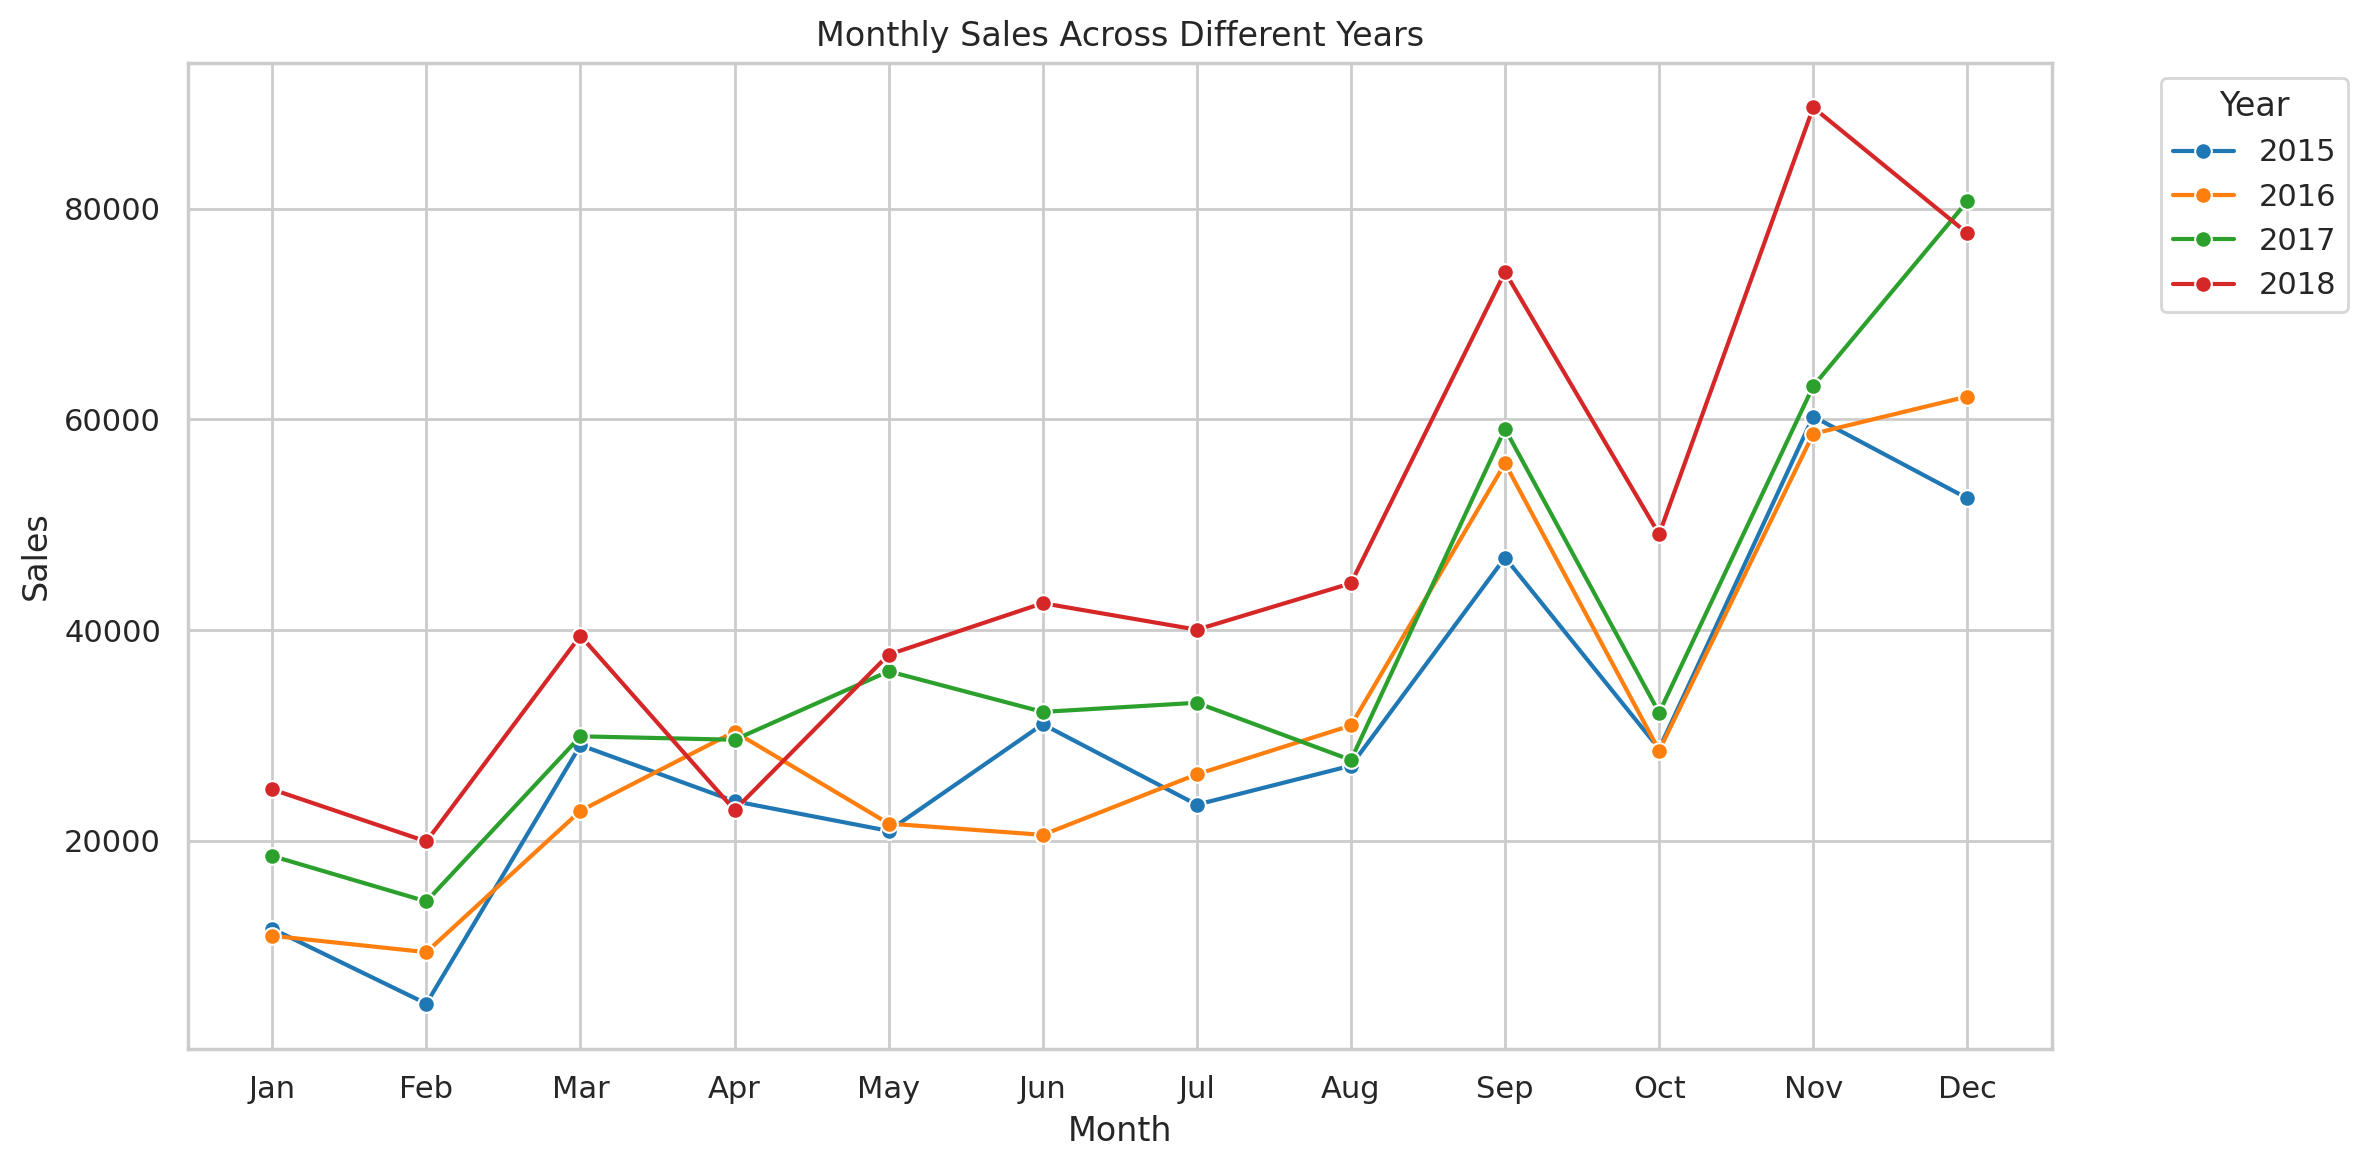

In [30]:
# Extract the month and year from the index
mdf['Month'] = mdf.index.month
mdf['Year'] = mdf.index.year

# Create a seasonal plot: Sales vs Month, colored by Year
plt.figure(figsize=(12, 6), dpi=200)
sns.lineplot(data=mdf, x='Month', y='Sales', hue='Year', marker='o', palette='tab10')

# Customize plot
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Monthly Sales Across Different Years')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

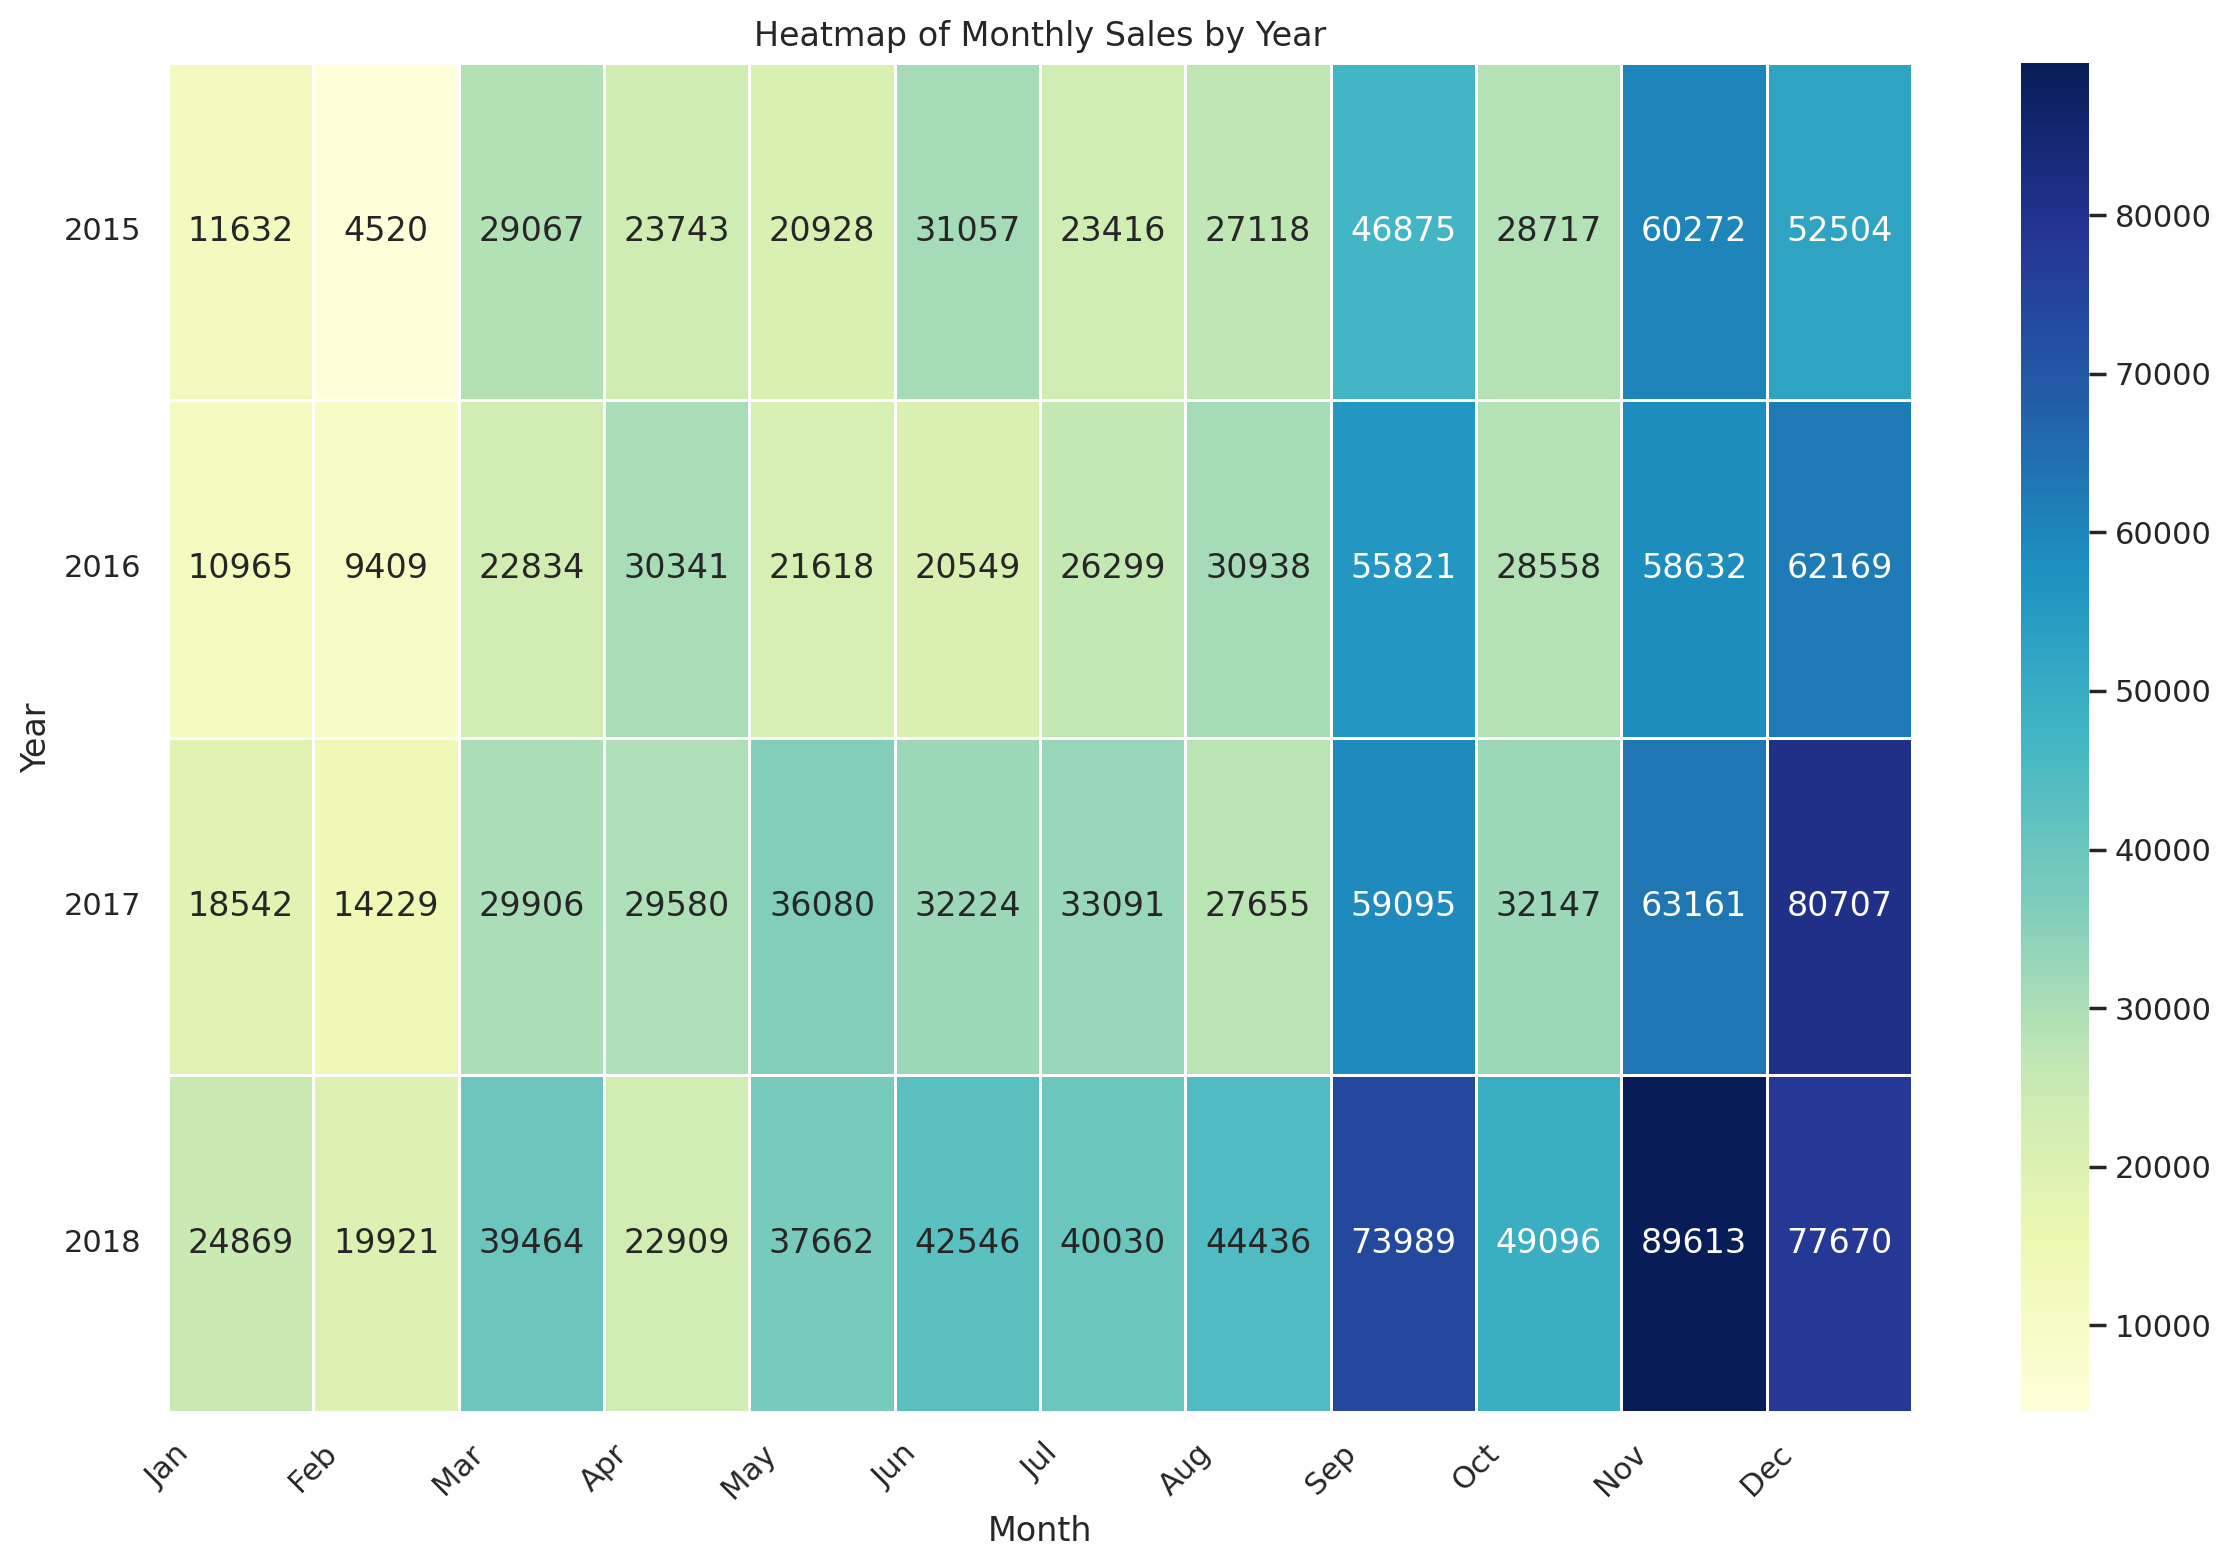

In [31]:
# Pivot the data to create a matrix of Sales by Year and Month
heatmap_data = mdf.pivot_table(index=mdf.index.year, columns=mdf.index.month, values='Sales', aggfunc='sum')

# Create a heatmap
plt.figure(figsize=(12, 8), dpi=200)
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt='.0f', linewidths=.5)

# Customize plot
plt.xlabel('Month')
plt.ylabel('Year')
plt.title('Heatmap of Monthly Sales by Year')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 7.5 Stationarity Check
<a id="stationarity-check"></a>

### Time Series Stationarity Check Workflow

1. **Visual Inspection**: Begin by plotting the time series to observe any trends, seasonality, or changes in variance over time. This step provides an initial understanding of whether the data might be non-stationary.
  
2. **Dickey-Fuller Test**: Conduct the Augmented Dickey-Fuller (ADF) test to statistically assess stationarity. The null hypothesis of this test is that the time series is non-stationary. If the p-value is ≤ 0.05, the null hypothesis is rejected, indicating that the series is stationary.

3. **Actions Based on ADF Results**:
   - **If Stationary (p-value ≤ 0.05)**: Proceed with time series modeling (e.g., ARIMA, SARIMA), and consider checking autocorrelation with ACF and PACF plots.
   - **If Non-Stationary (p-value > 0.05)**: Apply differencing to transform the series into a stationary one. If necessary, use additional techniques like log transformation or seasonal differencing. After transformations, re-run the Dickey-Fuller test to confirm stationarity before proceeding with modeling.

Time Series Plot: Visual Inspection


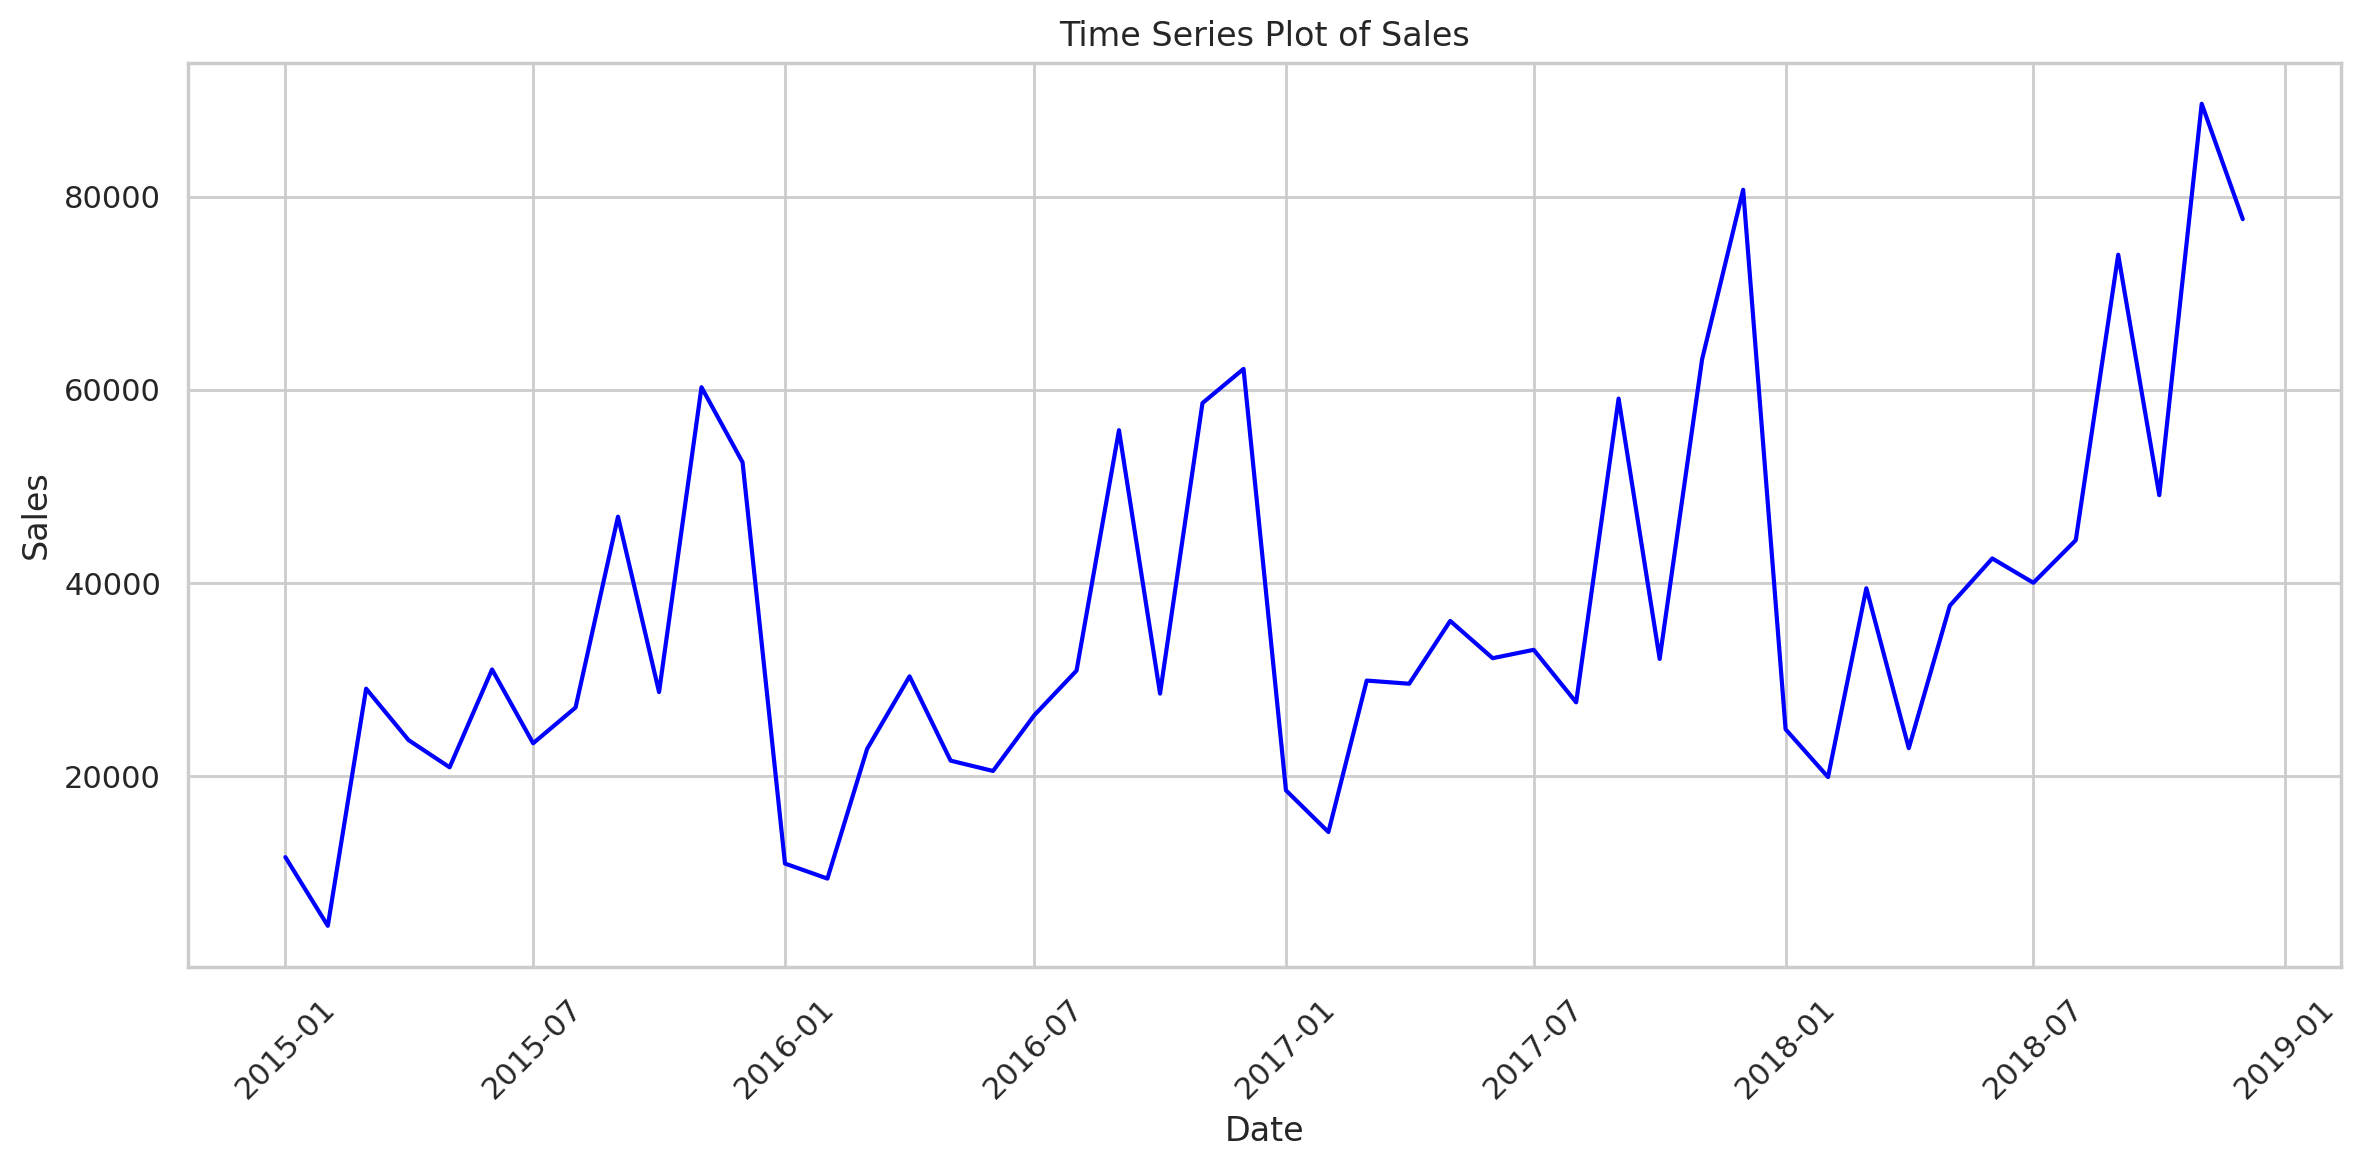

In [32]:
print("Time Series Plot: Visual Inspection")

# Plot the time series data
plt.figure(figsize=(12, 6), dpi=200)
sns.lineplot(data=mdf, x=mdf.index, y='Sales', color='blue')

# Customize plot
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Time Series Plot of Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [33]:
print("Statistical Tests: Dickey-Fuller Test")

# Perform the Dickey-Fuller test
adf_result = adfuller(mdf['Sales'])

# Extract and display the test statistic and p-value
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

# Conclusion based on p-value
if adf_result[1] <= 0.05:
    print("Reject the null hypothesis - The time series is stationary.")
else:
    print("Fail to reject the null hypothesis - The time series is non-stationary.")

Statistical Tests: Dickey-Fuller Test
ADF Statistic: -4.0172479218866055
p-value: 0.001322840741208308
Reject the null hypothesis - The time series is stationary.


## 7.6 Autocorrelation and Partial Autocorrelation
<a id="autocorrelation"></a>

1. **Autocorrelation Function (ACF) Plot**:
   - **Definition**: The ACF plot shows the correlation of a time series with its own past values (lags). It measures how the current value of the series is related to its past values at various lags.
   - **Purpose**: Helps identify the presence of patterns, periodicity, or seasonality in the data. It is useful for determining the order of the MA (Moving Average) component in time series models.

2. **Partial Autocorrelation Function (PACF) Plot**:
   - **Definition**: The PACF plot shows the correlation of a time series with its past values after removing the effects of intermediate lags. It measures the direct relationship between the current value and past values, excluding the influence of intermediate lags.
   - **Purpose**: Helps identify the direct effect of past values on the current value, useful for determining the order of the AR (Auto-Regressive) component in time series models.

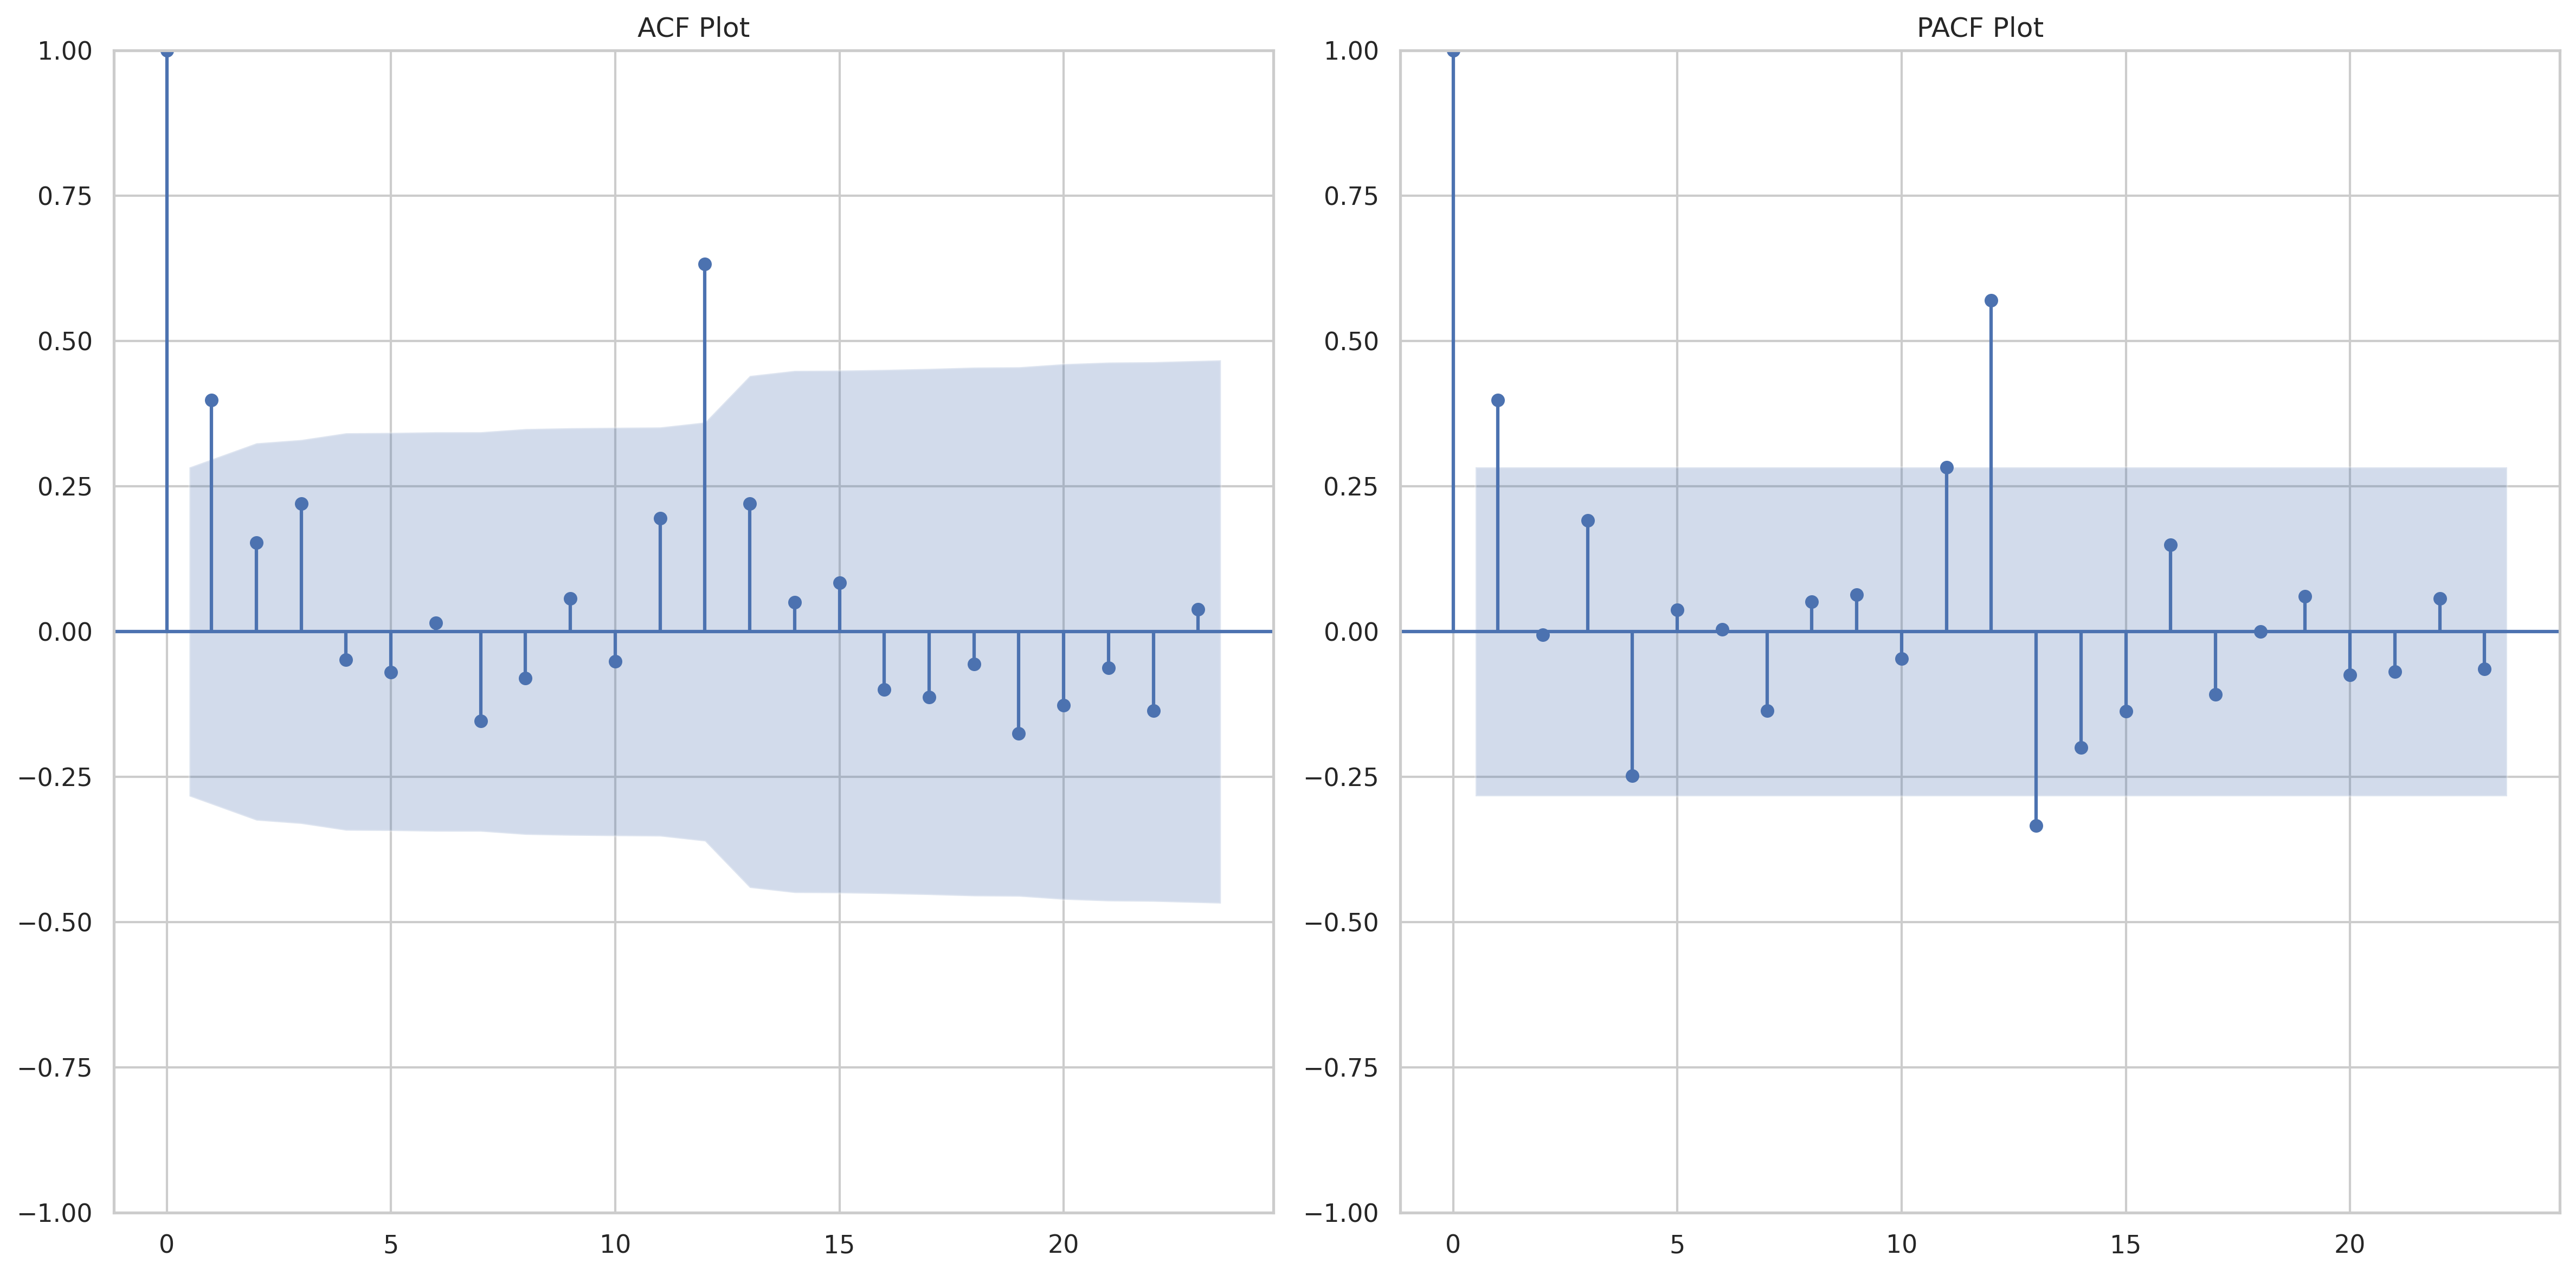

In [34]:
# Determine the maximum number of lags
max_lags = len(mdf) // 2 - 1

# Set the size and resolution of the plot
plt.figure(figsize=(16, 8), dpi=300)

# Plot ACF
plt.subplot(1, 2, 1)
plot_acf(mdf['Sales'], ax=plt.gca(), lags=max_lags)
plt.title('ACF Plot')

# Plot PACF
plt.subplot(1, 2, 2)
plot_pacf(mdf['Sales'], ax=plt.gca(), lags=max_lags)
plt.title('PACF Plot')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

### Determining AR and MA Orders from ACF and PACF

1. **Auto-Regressive (AR) Order**:
   - **PACF Analysis**: The AR order is typically the lag number at which the PACF values drop to near-zero. For the provided PACF values, the AR order could be around 12, where the PACF values start stabilizing.

2. **Moving Average (MA) Order**:
   - **ACF Analysis**: The MA order is typically the lag number at which the ACF values drop to near-zero. For the provided ACF values, the MA order could be around 12, where the ACF values start stabilizing.

## 7.7 Feature Impacts
<a id="feature-impacts"></a>

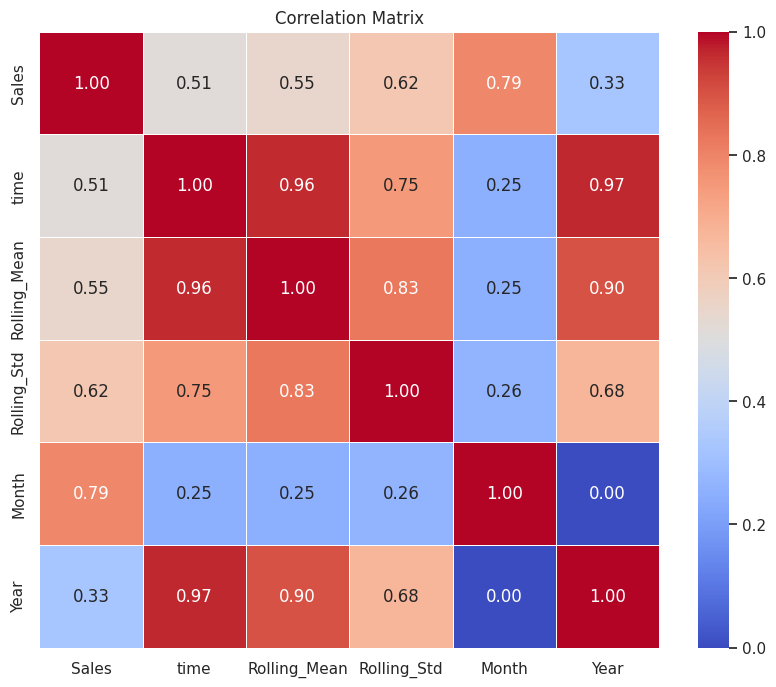

In [35]:
correlation_matrix = mdf.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# 8. Modelling
<a id="modelling"></a>

In [36]:
mdf.shape

(48, 6)

In [37]:
mdf.head()

,Sales,time,Rolling_Mean,Rolling_Std,Month,Year
month,,,,,,
2015-01-01,11631.887,0,NaN,NaN,1,2015
2015-02-01,4519.892,1,NaN,NaN,2,2015
2015-03-01,29067.387,2,NaN,NaN,3,2015
2015-04-01,23742.805,3,NaN,NaN,4,2015
2015-05-01,20928.373,4,NaN,NaN,5,2015


In [38]:
mdf.tail()

,Sales,time,Rolling_Mean,Rolling_Std,Month,Year
month,,,,,,
2018-08-01,44436.4080,43,42245.618275,17876.876876,8,2018
2018-09-01,73989.1270,44,43486.829917,19588.227699,9,2018
2018-10-01,49095.6272,45,44899.199100,19305.249404,10,2018
2018-11-01,89613.2310,46,47103.556117,22777.904248,11,2018
2018-12-01,77670.4768,47,46850.480767,22384.071384,12,2018


In [39]:
forecast_steps = 12

In [40]:
train_mdf = mdf.iloc[:48 - forecast_steps]
test_mdf = mdf.iloc[48 - forecast_steps:forecast_steps + 48]

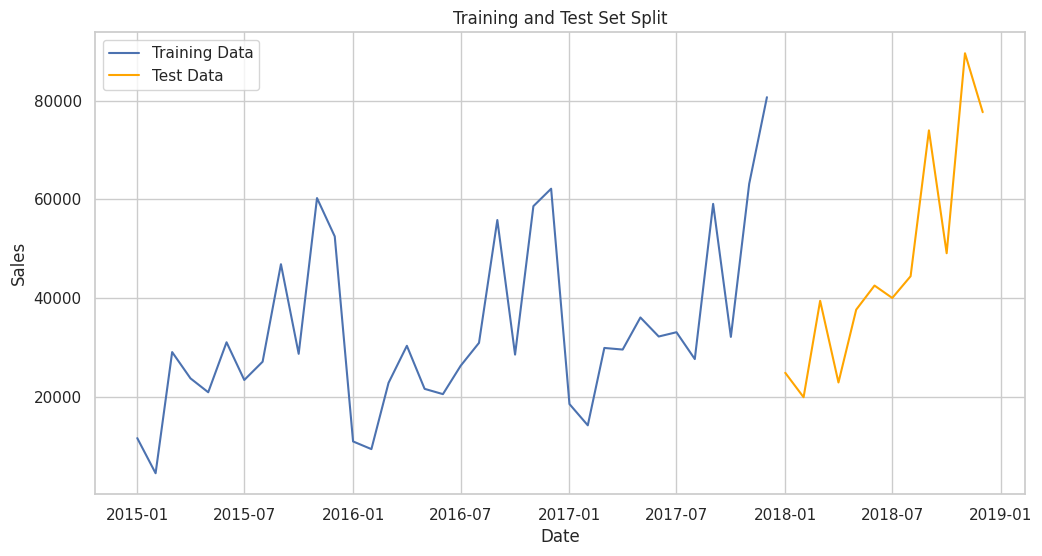

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(train_mdf.index, train_mdf['Sales'], label='Training Data')
plt.plot(test_mdf.index, test_mdf['Sales'], label='Test Data', color='orange')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Training and Test Set Split')
plt.legend()
plt.show()

## 8.1 ARIMA
<a id="arima"></a>

In [42]:
p, d, q = forecast_steps, 0, forecast_steps
arma_model = ARIMA(train_mdf['Sales'], order=(p, d, q))
arma_results = arma_model.fit()

In [43]:
forecast = arma_results.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()
forecast_index = pd.date_range(start=train_mdf.index[-1] + pd.DateOffset(1), periods=forecast_steps, freq='M')
forecast_mean.index = pd.to_datetime(forecast_mean.index)
forecast_df = forecast_mean.to_frame(name='Forecast')

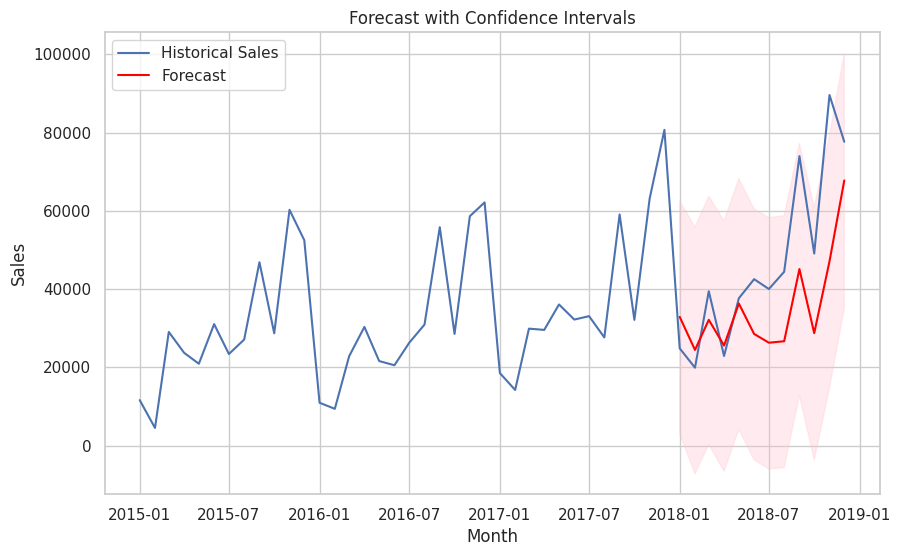

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(mdf.index, mdf['Sales'], label='Historical Sales')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red')
plt.fill_between(forecast_index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Forecast with Confidence Intervals')
plt.legend()
plt.show()

In [45]:
mae = mean_absolute_error(test_mdf['Sales'], forecast_df['Forecast'][:len(test_mdf)])
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 14248.479945184657


In [46]:
mse = mean_squared_error(test_mdf['Sales'], forecast_df['Forecast'][:len(test_mdf)])
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 333294706.7007579


In [47]:
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 18256.36071895924


## 8.2 SARIMA
<a id="sarima"></a>

In [49]:
p, d, q = 1, 1, 1
P, D, Q, S = 1, 1, 1, 12

sarima_model = SARIMAX(train_mdf['Sales'],
                       order=(p, d, q),
                       seasonal_order=(P, D, Q, S))
sarima_results = sarima_model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [50]:
forecast_steps = forecast_steps
forecast = sarima_results.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

In [51]:
forecast_index = pd.date_range(start=train_mdf.index[-1] + pd.DateOffset(1), periods=forecast_steps, freq='M')
forecast_mean.index = pd.to_datetime(forecast_mean.index)
forecast_df = forecast_mean.to_frame(name='Forecast')

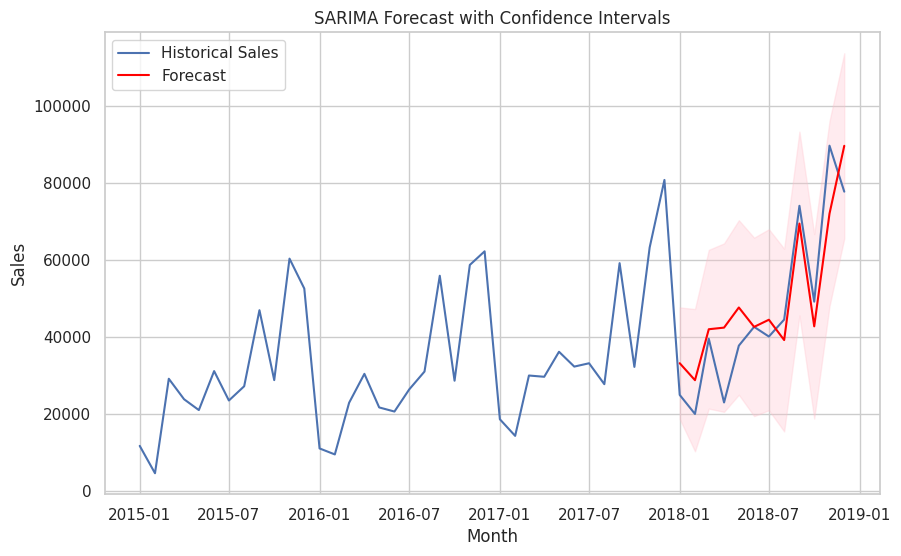

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(mdf.index, mdf['Sales'], label='Historical Sales')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red')
plt.fill_between(forecast_df.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('SARIMA Forecast with Confidence Intervals')
plt.legend()
plt.show()

In [53]:
mae = mean_absolute_error(test_mdf['Sales'], forecast_df['Forecast'])
print(f"Mean Absolute Error (MAE): {mae}")

mse = mean_squared_error(test_mdf['Sales'], forecast_df['Forecast'])
print(f"Mean Squared Error (MSE): {mse}")

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 8260.603311384242
Mean Squared Error (MSE): 99237626.13188028
Root Mean Squared Error (RMSE): 9961.808376589077


## 8.3 FB Prophet
<a id="fb-prophet"></a>

In [54]:
df_prophet = mdf.reset_index()

In [55]:
df_prophet = df_prophet[["month", "Sales"]]

In [56]:
df_prophet.columns = ['ds', 'y']

In [57]:
train_prophet = df_prophet.iloc[:48 - forecast_steps]
test_prophet = df_prophet.iloc[48 - forecast_steps:forecast_steps + 48]

In [58]:
model = Prophet()
model.fit(train_prophet)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppcznp9wz/4xvmjv3m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppcznp9wz/h0tumgmz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12762', 'data', 'file=/tmp/tmppcznp9wz/4xvmjv3m.json', 'init=/tmp/tmppcznp9wz/h0tumgmz.json', 'output', 'file=/tmp/tmppcznp9wz/prophet_modelp28r12nb/prophet_model-20250120135858.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:58:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:58:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [59]:
future = test_prophet[['ds']]

In [60]:
forecast = model.predict(future)

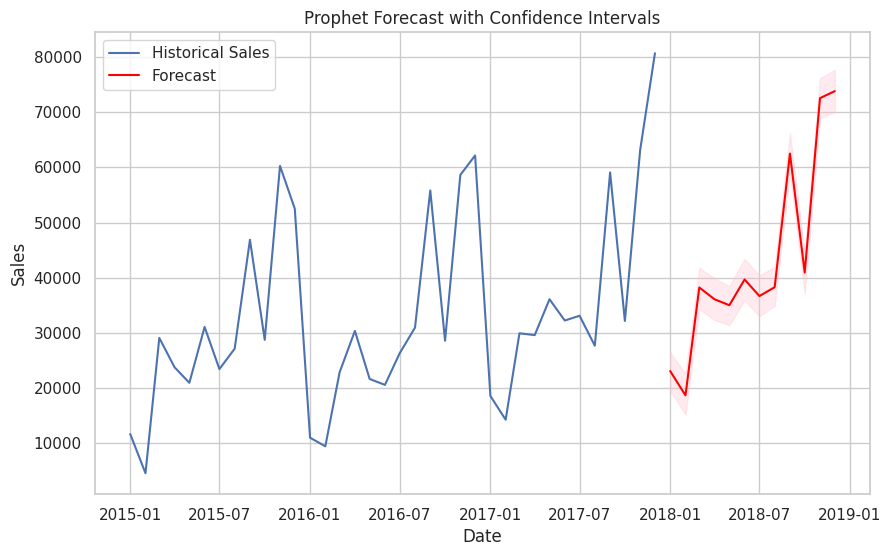

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(train_prophet['ds'], train_prophet['y'], label='Historical Sales')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='red')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Prophet Forecast with Confidence Intervals')
plt.legend()
plt.show()

In [62]:
actual = test_prophet['y'].values
forecasted = forecast['yhat'].values

In [63]:
mae = mean_absolute_error(actual, forecasted)
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 6092.627044063928


In [64]:
mse = mean_squared_error(actual, forecasted)
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 62376967.0280526


In [65]:
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 7897.909028853941
